In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libs

In [ ]:
# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Загрузка сохраненной модели
from tensorflow.keras.models import load_model
# Готовые датасеты
from tensorflow.keras.datasets import mnist, fashion_mnist

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# класс для использования Functional API
from tensorflow.keras import Model

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split 

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Функции операционной системы
import os

# Работа со временем
import time

# Отрисовка графиков
import matplotlib.pyplot as plt 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import os
# Работа со временем
import time
from scipy.ndimage import zoom
import random

from sklearn.preprocessing import MinMaxScaler
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import librosa
import pickle
from scipy.stats import mode

# Задача 1; Восстановление геометрии (обратная задача)
На вход подается радорограмма формати (128, 128, 1) (!!! кол-во входов меняется при использовании Add librosa features); на выход подается геометрия (эл-физ свойства профиля) формата (128, 128, 2) - каждый канал соответствует одному свойству (здесь диэлектрическая проницаемость и проводимость)


## Giperparams

In [ ]:
IMG_HEIGHT, IMG_WIDTH, GEOM_CHANNELS = 128, 128, 2

VAL_SPLIT = 0.1
GEOM_CHANNELS = 2
folder = 'drive/MyDrive/dataset_2/'
EPOCHS = 100
DURATION_SEC = 30*10**(-9)

## Service functions

In [ ]:
def load_bscans_and_geometry_two_dim(folder, height, width, channels): 
    bscans_list = []                       # Список для радарограмм
    geometry_list = []
    for bscan in os.listdir(folder):        # Перебор по именам файлов в папке
        # Добавление в список изображения в виде массива,
        # в заданных размерах и в оттенках серого
        if 'bscan_' in bscan:
            bscans_list.append(zoom(np.load(os.path.join(folder, bscan)), (1,0.25)).T)
            # print(folder+'\\'+bscan)
            geom_name=f'geom{bscan[5:-4]}.npy'
            geom_np = np.load(os.path.join(folder, geom_name))

            ### переделываем геометрию, т.к. заданы неверные параметры в датасете
            new_geom = np.zeros((height, width, channels),)
            
            new_geom[:,:,1] = 0 # Блок сигмы

            ### правка, добавляем нули сверху
            # new_geom[:geom_np.shape[0],width-geom_np.shape[0]:geom_np.shape[1],:GEOM_CHANNELS] = geom_np
            new_geom[height-geom_np.shape[0]:,width-geom_np.shape[1]:,:GEOM_CHANNELS] = geom_np[:,:,:GEOM_CHANNELS]
            # new_geom[new_geom == 1] = 100
            new_geom[:,:3,0] = 5 # Блок епсилон, диэлектрической проницаемости ## to do блять. с геометрией намудрил
            new_geom[:3,:,0] = 1
            geometry_list.append(new_geom)

    # делаем решейп            
    bscans_array, geometry_array = np.array(bscans_list), np.array(geometry_list)
    
    bscans_array = bscans_array.reshape([bscans_array.shape[0], 
                                   bscans_array.shape[1], 
                                   bscans_array.shape[2], 
                                   1])
    
        # делаем решейп            
    geometry_array = geometry_array.reshape([geometry_array.shape[0], 
                                   geometry_array.shape[1], 
                                   geometry_array.shape[2], 
                                   GEOM_CHANNELS])
    # Возврат массива-результата
    return bscans_array, geometry_array

from matplotlib.colors import LogNorm
from pylab import figure, cm

def visualizate_random_dataset_sample(x, y):
  rand = random.randint(1, len(x)-1)
  bscan = x[rand]
  geom = y[rand]

  fig, ax = plt.subplots(1, 3, figsize = (15,15))
  ax[0].set_title('Радарограмма')
  im0 = ax[0].imshow(bscan[:, :,0])
  divider = make_axes_locatable(ax[0])
  ax_cb0 = divider.append_axes("right", size="5%", pad=0.05)
  fig0 = ax[0].get_figure()
  fig0.add_axes(ax_cb0)
  plt.colorbar(im0, cax=ax_cb0)
  
  ax[1].set_title('Геометрия, ε')
  im1 = ax[1].imshow(geom[:, :,0])
  im1 = ax[1].imshow(geom[:, :,0])
  divider = make_axes_locatable(ax[1])
  
  ax_cb = divider.append_axes("right", size="5%", pad=0.05)
  fig2 = ax[1].get_figure()
  fig2.add_axes(ax_cb)
  plt.colorbar(im1, cax=ax_cb)

  ax[2].set_title('Геометрия, sigma')
  im2 = ax[2].imshow(geom[:, :, 1])
  divider = make_axes_locatable(ax[2])
  ax_cb2 = divider.append_axes("right", size="5%", pad=0.05)
  fig2 = ax[2].get_figure()
  fig2.add_axes(ax_cb2)
  plt.colorbar(im2, cax=ax_cb2)

  plt.show()

def normalization(dataset):
  max = np.abs(dataset).max()
  min = dataset.min()
#   dataset = (dataset -min)/(max - min)
  dataset = (dataset)/(max)
  def transform(x, max = max, min=min):
    return x*max
  return dataset, transform

def process_images(model,        # обученная модель
                  #  count = 3     # количество случайных картинок для сегментации
                   ):
  
    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
  indexes = np.random.randint(0, len(X_test), count)

  bscans = X_test[indexes]
  orig_geom = y_test[indexes]
  # Вычисление предсказания сети для картинок с отобранными индексами
  predict = model.predict(bscans)
  print(predict.min(), predict.max() )

  # Подготовка цветов классов для отрисовки предсказания

  fig, axs = plt.subplots(2, 2, figsize=(25, 15)) 
  for i in range(count):
      # Отображение на графике в первой линии предсказания модели
      axs[0, 0].set_title('Bscan:')
      axs[i, 0].imshow(bscans[i][:,:,0])
      axs[i, 0].axis('off')

      # Отображение на графике во второй линии сегментированного изображения из y_val
      axs[0, 1].set_title('Orig_geom')
      axs[i, 1].imshow(orig_geom[i][:,:,0])
      axs[i ,1].axis('off')

      # Отображение на графике в третьей линии оригинального изображения
      # axs[0, 2].set_title('Pred_geom')
      # axs[i, 2].imshow(predict[i][:,:,0])
      # axs[i ,2].axis('off')

  plt.show()

def show_predict_random_sample(model, X, y,       # обученная модель
                   count = 1,     # количество случайных картинок для сегментации
                   ):
  
    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
  indexes = np.random.randint(0, len(X_test), count)

  bscans = X[indexes]
  orig_geom = y[indexes]
  # Вычисление предсказания сети для картинок с отобранными индексами
  predict = model.predict(bscans)
  # print(predict.min(), predict.max() )

  # Подготовка цветов классов для отрисовки предсказания

  fig, axs = plt.subplots(2, 3, figsize=(15, 10)) 
  for i in range(count):
      axs[0, 0].set_title('Bscan:')
      axs[0, 0].imshow(bscans[i][:,:,0])
      axs[0, 0].axis('off')

      axs[0, 1].set_title('Orig_geom, ε')
      # matshow(geom[:, :,0], cmap=cm.gray_r, norm=LogNorm(vmin=0.01, vmax=1))

      axs[0, 1].imshow(orig_geom[i][:,:,0])
      axs[0 ,1].axis('off')

      axs[0, 2].set_title('Orig_geom, sigma')
      axs[0, 2].imshow(orig_geom[i][:,:,1])
      axs[0 ,2].axis('off')

      axs[1, 0].set_title('Add information:')
      axs[1, 0].imshow(bscans[i][:,:,0])
      axs[1, 0].axis('off')

      axs[1, 1].set_title('Pred_geom, ε')
      axs[1, 1].imshow(predict[i][:,:,0])
      axs[1 ,1].axis('off')

      axs[1, 2].set_title('Pred_geom, sigma')
      axs[1, 2].imshow(predict[i][:,:,1])
      axs[1 ,2].axis('off')

  plt.show()

## Обработка и визуализация датасета

### Загрузка

In [ ]:
# cur_time = time.time()
# data_bscans, data_geometry = load_bscans_and_geometry_two_dim(folder, IMG_HEIGHT, IMG_WIDTH, GEOM_CHANNELS)

# print(f'Время загрузки: {round(time.time()-cur_time)} с.')
# print(f'Размер bscans: {data_bscans.shape}; размер geoms{data_geometry.shape}')

# visualizate_random_dataset_sample(data_bscans, data_geometry)

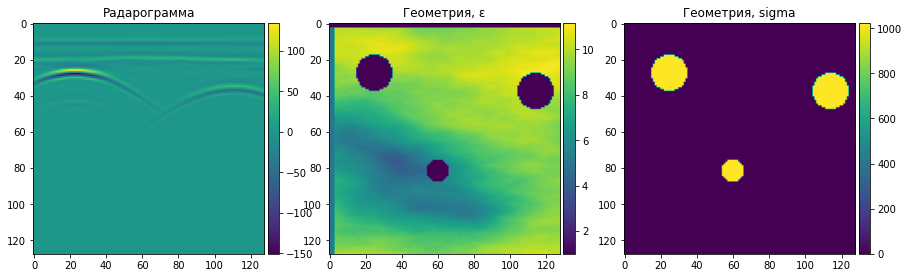

In [ ]:
# with open(os.path.join(folder, 'data.pickle'), 'wb') as f:
#     pickle.dump((data_bscans, data_geometry), f)

with open(os.path.join(folder, 'data.pickle'), 'rb') as f:
    data_bscans, data_geometry = pickle.load(f)

visualizate_random_dataset_sample(data_bscans, data_geometry)

### Add librosa features

In [ ]:
cur_time = time.time()
a_sample = np.load(os.path.join(folder, 'bscan_001000.npy')).T[::4,:]
# SR = 1/(DURATION_SEC)
bscan_shape = a_sample.shape
SR = int(1/(DURATION_SEC/bscan_shape[0]))
HOP_LENGTH = 1
# print(SR)
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
N_FFT = 16
FRAME_LENGTH = 2


def add_librosa_features(a_sample):
  a_sample = a_sample[:,:,0]
  # [librosa.feature.zero_crossing_rate(a_sample[:,x], frame_length=2, hop_length=1) for x in range(bscan_shape[1])]
  chroma_stft = np.array([librosa.feature.chroma_stft(y = a_sample[:,x], sr = SR, n_fft = N_FFT, hop_length=HOP_LENGTH) for x in range(bscan_shape[1])])[:,0,:-1].T
  # Мел-кепстральные коэффициенты
  mfcc = np.array([librosa.feature.mfcc(y = a_sample[:,x], sr = SR, n_fft = N_FFT, hop_length=HOP_LENGTH) for x in range(bscan_shape[1])])[:,0,:-1].T
  # # Среднеквадратическая амплитуда
  # rmse = librosa.feature.rms(y = a_sample, hop_length=HOP_LENGTH)
  rmse = np.array([librosa.feature.rms(a_sample[:,x], frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH) for x in range(bscan_shape[1])])[:,0,:-1].T
  # # Спектральный центроид
  spec_cent = np.array([librosa.feature.spectral_centroid(y = a_sample[:,x], sr = SR, n_fft = N_FFT, hop_length=HOP_LENGTH) for x in range(bscan_shape[1])])[:,0,:-1].T
  # Ширина полосы часто
  spec_bw = np.array([librosa.feature.spectral_bandwidth(y = a_sample[:,x], sr = SR, n_fft = N_FFT, hop_length=HOP_LENGTH) for x in range(bscan_shape[1])])[:,0,:-1].T
  # # Спектральный спад частоты
  rolloff = np.array([librosa.feature.spectral_rolloff(y = a_sample[:,x], sr = SR, n_fft = N_FFT, hop_length=HOP_LENGTH) for x in range(bscan_shape[1])])[:,0,:-1].T
  # # Пересечения нуля
  zcr = np.array([librosa.feature.zero_crossing_rate(a_sample[:,x], frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH) for x in range(bscan_shape[1])])[:,0,:-1].T
  sample = np.squeeze(np.stack(([a_sample], [chroma_stft], [mfcc], [rmse], [spec_cent], [spec_bw], [rolloff], [zcr]), axis=3), 0)
  return(sample)

# data_bscans = np.array([add_librosa_features(x) for x in data_bscans])
# print(f'Время загрузки: {(time.time()-cur_time)} с.')

/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/usr/local/lib/python3.8/dist-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


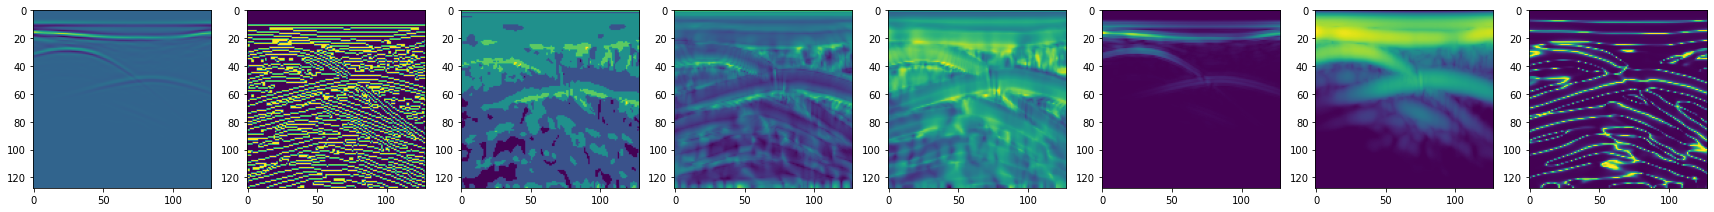

In [ ]:
cur_time = time.time()
a_sample = np.load(os.path.join(folder, 'bscan_001000.npy')).T[::4,:]
# SR = 1/(DURATION_SEC)
bscan_shape = a_sample.shape
SR = int(1/(DURATION_SEC/bscan_shape[0]))
HOP_LENGTH = 1
# print(SR)
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
N_FFT = 16
FRAME_LENGTH = 2


# a_sample = a_sample[:,:,0]
# [librosa.feature.zero_crossing_rate(a_sample[:,x], frame_length=2, hop_length=1) for x in range(bscan_shape[1])]
chroma_stft = np.array([librosa.feature.chroma_stft(y = a_sample[:,x], sr = SR, n_fft = N_FFT, hop_length=HOP_LENGTH) for x in range(bscan_shape[1])])[:,0,:-1].T
# Мел-кепстральные коэффициенты
mfcc = np.array([librosa.feature.mfcc(y = a_sample[:,x], sr = SR, n_fft = N_FFT, hop_length=HOP_LENGTH) for x in range(bscan_shape[1])])[:,0,:-1].T
# # Среднеквадратическая амплитуда
# rmse = librosa.feature.rms(y = a_sample, hop_length=HOP_LENGTH)
rmse = np.array([librosa.feature.rms(a_sample[:,x], frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH) for x in range(bscan_shape[1])])[:,0,:-1].T
# # Спектральный центроид
spec_cent = np.array([librosa.feature.spectral_centroid(y = a_sample[:,x], sr = SR, n_fft = N_FFT, hop_length=HOP_LENGTH) for x in range(bscan_shape[1])])[:,0,:-1].T
# Ширина полосы часто
spec_bw = np.array([librosa.feature.spectral_bandwidth(y = a_sample[:,x], sr = SR, n_fft = N_FFT, hop_length=HOP_LENGTH) for x in range(bscan_shape[1])])[:,0,:-1].T
# # Спектральный спад частоты
rolloff = np.array([librosa.feature.spectral_rolloff(y = a_sample[:,x], sr = SR, n_fft = N_FFT, hop_length=HOP_LENGTH) for x in range(bscan_shape[1])])[:,0,:-1].T
# # Пересечения нуля
zcr = np.array([librosa.feature.zero_crossing_rate(a_sample[:,x], frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH) for x in range(bscan_shape[1])])[:,0,:-1].T
# print(a_sample.shape, zcr.shape, rolloff.shape, spec_bw.shape, spec_cent.shape, rmse.shape, mfcc.shape, chroma_stft.shape)
fig, ax = plt.subplots(1, 8, figsize=(30, 20)) 
ax[0].imshow(a_sample)
ax[1].imshow(zcr)
ax[2].imshow(rolloff)
ax[3].imshow(spec_bw)
ax[4].imshow(spec_cent)
ax[5].imshow(rmse)
ax[6].imshow(mfcc)
ax[7].imshow(chroma_stft)

In [ ]:
# with open(os.path.join(folder, 'data_librosa.pickle'), 'wb') as f:
#     pickle.dump(data_bscans, f)

with open(os.path.join(folder, 'data_librosa.pickle'), 'rb') as f:
    data_bscans = pickle.load(f)

data_bscans.shape

KeyboardInterrupt: ignored

In [ ]:
data_bscans[:,:,:,7].shape

### Scaller

In [ ]:
data_bscans_scall = np.zeros_like(data_bscans)
data_bscans_scall[:,:,:,0], scall = normalization(data_bscans[:,:,:,0])
data_bscans_scall[:,:,:,1], scall = normalization(data_bscans[:,:,:,1])
data_bscans_scall[:,:,:,2], _ = normalization(data_bscans[:,:,:,2])
data_bscans_scall[:,:,:,3], _ = normalization(data_bscans[:,:,:,3])
data_bscans_scall[:,:,:,4], _ = normalization(data_bscans[:,:,:,4])
data_bscans_scall[:,:,:,5], _ = normalization(data_bscans[:,:,:,5])
data_bscans_scall[:,:,:,6], _ = normalization(data_bscans[:,:,:,6])
data_bscans_scall[:,:,:,7], _ = normalization(data_bscans[:,:,:,7])
# не работает, надо разбирать
# data_bscans_scall = [normalization(data_bscans[:,:,:,i])[0] for i in range(data_bscans.shape[3])] 
data_geometry_scall = np.zeros_like(data_geometry)
data_geometry_scall[:,:,:,0], geometry_eps_scaller = normalization(data_geometry[:,:,:,0])
data_geometry_scall[:,:,:,1], geometry_sigma_scaller = normalization(data_geometry[:,:,:,1])

visualizate_random_dataset_sample(data_bscans_scall, data_geometry_scall)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data_bscans_scall, data_geometry_scall,
    test_size=VAL_SPLIT, 
    random_state=42)
visualizate_random_dataset_sample(X_test, y_test)

In [ ]:
IMAGE_CHANNELS = X_train.shape[3]
print(IMAGE_CHANNELS)

## Model sunet

### Create and fit 

In [ ]:
def sunet(input_shape,
          class_count):
  img_input = Input(input_shape)   
  x = BatchNormalization()(img_input)
  ''' Block 1 '''
  block_1_out = Conv2D(32, (12, 12), padding='same', name='block1_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_1_out) 

  # ''' Block 2 '''
  block_2_out = Conv2D(64, (5,5), padding='same', name='block2_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_2_out) 

  # ''' Block 3 '''
  block_3_out = Conv2D(128, (3,3), padding='same', name='block3_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_3_out)

  # ''' Block 4 '''
  block_4_out = Conv2D(256, (3,3), padding='same', name='block4_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_4_out)

  # ''' UP 1 '''
  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_4_out])
  x = Conv2D(256, (3, 3), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # x = Conv2D(128, (3,3), padding='same', activation = 'relu')(x)

  # ''' UP 2 '''
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_3_out])
  x = Conv2D(128, (3, 3), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x)  

  # ''' UP 3 '''
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_2_out])
  x = Conv2D(64, (5, 5), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x) 


  # ''' UP 4 '''
  x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_1_out])
  x = Conv2D(32, (12, 12), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x) 

  x = Conv2D(class_count, (3, 3), padding='same', activation = 'sigmoid')(x)




  model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

  # Компилируем модель
  model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='mse',
                metrics=['mae'])

  # Возвращаем сформированную модель
  return model

In [ ]:
model_sunet = sunet((IMG_WIDTH, IMG_HEIGHT, IMAGE_CHANNELS), GEOM_CHANNELS)

model_sunet.summary()
# utils.plot_model(model_sunet, show_shapes=True, dpi=40)

In [ ]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.1, 
                                      patience=5, 
                                      verbose=0,
                                      min_lr=0.000000001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'sunet_geometry'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=True)

history = model_sunet.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True,
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                             model_checkpoint_callback
                             ],
                          )

### Visualizate

In [ ]:
 show_predict_random_sample(model_sunet, X_test, y_test)

## Model unet

### Create and fit 

In [ ]:
def unet(input_shape,
          class_count):
  img_input = Input(input_shape)   

  ''' Block 1 '''
  block_1_out = Conv2D(32, (15, 15), padding='same', name='block1_conv1', activation = 'relu')(img_input)
  x = MaxPooling2D()(block_1_out) 

  # ''' Block 2 '''
  block_2_out = Conv2D(64, (5,5), padding='same', name='block2_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_2_out) 

  # ''' Block 3 '''
  block_3_out = Conv2D(128, (3,3), padding='same', name='block3_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_3_out)

  # ''' Block 4 '''
  block_4_out = Conv2D(256, (3,3), padding='same', name='block4_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_4_out)

  # ''' UP 1 '''
  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_4_out])
  x = Conv2D(256, (3, 3), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # x = Conv2D(128, (3,3), padding='same', activation = 'relu')(x)

  # ''' UP 2 '''
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_3_out])
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)  

  # ''' UP 3 '''
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_2_out])
  x = Conv2D(64, (5, 5), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x) 


  # ''' UP 4 '''
  x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_1_out])
  x = Conv2D(32, (12, 12), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x) 

  x = Conv2D(class_count, (3, 3), padding='same', activation = 'sigmoid')(x)

  model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

  # Компилируем модель
  model.compile(optimizer=Adam(learning_rate=1e-3),
                loss='mse',
                metrics=['mae'])

  # Возвращаем сформированную модель
  return model

In [ ]:
model_unet = unet((IMG_WIDTH, IMG_HEIGHT, IMAGE_CHANNELS), GEOM_CHANNELS)
# utils.plot_model(model_unet, show_shapes=True, dpi=40)
model_unet.summary()

In [ ]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_mae', 
                                      factor=0.1, 
                                      patience=10, 
                                      verbose=0,
                                      min_lr=0.00000000001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'unet'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True
    )

model_unet.compile(optimizer=Adam(learning_rate=1e-2),
                loss='mse',
                metrics=['mae'])

history = model_unet.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                             model_checkpoint_callback
                         ],
                         )

### Visualizate

In [ ]:
 show_predict_random_sample(model_unet, X_test, y_test)

## Model AE

### Create and fit 

In [ ]:
# Функция сборки свёрточного автокодировщика
def create_base_ae(in_shape, geom_channels):

  # Входной слой 
  inputs = Input(in_shape)

  # Энкодер
  # ---------------------------------------------------------------

  # 3 блока свертки перед сжатием 
  x = Conv2D(12, 3, padding='same', activation='relu')(inputs)
  x = BatchNormalization()(x)

  # используем разрежение (dilation_rate) для выявления мелких деталей изображения
  x = Conv2D(24, 3, dilation_rate=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 1
  x = Conv2D(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(96, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 2
  x = Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(256, 3, padding='same', activation='relu')(x)

  # Скрытое пространство
  z = BatchNormalization()(x)

  # Декодер
  # ---------------------------------------------------------------
  # Расширение 2
  x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(z)
  x = BatchNormalization()(x)

  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Расширение 1
  x = Conv2DTranspose(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(24, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(8, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # финальный слой свертки, выход модели
  outputs = Conv2D(geom_channels, 2, dilation_rate=2, padding='same', activation='sigmoid')(x)

  # Сборка модели. На входе оригинальное изображение, на выходе - сжатое-восстановленное
  model = Model(inputs, outputs)

  # компиляция модели
  model.compile(optimizer=Adam(1e-3),
                loss='mse',
                metrics = 'mae')

  return model

In [ ]:
model_ae = create_base_ae((IMG_WIDTH, IMG_HEIGHT, IMAGE_CHANNELS), GEOM_CHANNELS)
utils.plot_model(model_ae, show_shapes=True, dpi=40)
# model_ae.summary()

In [ ]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_mae', 
                                      factor=0.1, 
                                      patience=10, 
                                      verbose=0,
                                      min_lr=0.000000000000000001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'base_ae'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True)



model_ae.load_weights(checkpoint_filepath)

model_ae.compile(optimizer=Adam(1e-3),
                loss='mse',
                metrics = 'mae')

history = model_ae.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                             model_checkpoint_callback
                             ])

### Visualizate

In [ ]:
 show_predict_random_sample(model_ae, X_test, y_test)

## Model sequential_segmentation_net

In [ ]:
def sequential_segmentation_net(class_count,  # количество классов
                                input_shape   # форма входного изображения
                                ):

    img_input = Input(input_shape)                                              # Создаем входной слой формой input_shape
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)   

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv3')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv4')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)     

    x = Conv2D(16, (3, 3), padding='same', name='block1_conv5')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)           
       
    x = Conv2D(class_count, (3, 3), activation='sigmoid', padding='same')(x)    # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                                 # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-2),
                  loss='mse',
                  metrics=['mae'],
                  )
    
    # Возвращаем сформированную модель
    return model 

# Создание модели и вывод сводки по архитектуре

model_seq = sequential_segmentation_net(GEOM_CHANNELS ,
                                       (IMG_WIDTH, IMG_HEIGHT, IMAGE_CHANNELS))

# model_seq.summary()
utils.plot_model(model_seq, show_shapes=True, dpi=40)
model_seq.summary()

In [ ]:
# Обучение модели

reduceLROnPlateau = ReduceLROnPlateau(monitor='val_mae', 
                                      factor=0.1, 
                                      patience=10, 
                                      verbose=0,
                                      min_lr=0.0000000001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)
model_seq.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mae'],
                  )
checkpoint_filepath = folder + 'seg'
model_seq.load_weights(checkpoint_filepath)

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True)

history = model_seq.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                             model_checkpoint_callback
                             ],
                        )

### Visualizate

In [ ]:
 show_predict_random_sample(model_seq, X_test, y_test)

## Расширенная архитектура U-net


In [ ]:
def masked_unet(class_count,  # количество классов
                input_shape   # форма входного изображения
                ):
  
    img_input = Input(input_shape)                                              # Создаем входной слой формой input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv2D(64, (1, 1), padding='same')(block_1_out)          # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out)                                             # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)             # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)             # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(128, (1, 1), padding='same')(block_2_out)         # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling2D()(block_2_out)                                             # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(256, (1, 1), padding='same')(block_3_out)         # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling2D()(block_3_out)                                             # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(512, (1, 1), padding='same')(block_4_out)         # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling2D()(block_4_out)                                             # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling2D()(x)                                   # Добавляем слой MaxPooling2D
 
    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)         # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                         # Объединяем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(512, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)         # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                         # Объединяем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(256, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)         # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                         # Объединяем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(128, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)          # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                         # Объединяем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(64, (3, 3), padding='same')(x)                                   # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                                   # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='sigmoid', padding='same')(x)    # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                                 # Создаем модель с входом 'img_input' и выходом 'x'
    
    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-2),
                  loss='mse',
                  metrics=['mae'])
    
    # Возвращаем сформированную модель
    return model

In [ ]:
model_masked_unet = masked_unet(GEOM_CHANNELS, (IMG_WIDTH, IMG_HEIGHT, IMAGE_CHANNELS), )
utils.plot_model(model_masked_unet, show_shapes=True, dpi=40)
model_masked_unet.summary()

In [ ]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_mae', 
                                      factor=0.1, 
                                      patience=10, 
                                      verbose=0,
                                      min_lr=0.00000000001)
earlystop=EarlyStopping(monitor='val_mae', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'extended_unet'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True)

model_masked_unet.load_weights(checkpoint_filepath)
# Компилируем модель
model_masked_unet.compile(optimizer=Adam(learning_rate=1e-4),
              loss='mse',
              metrics=['mae'])



history = model_masked_unet.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                             model_checkpoint_callback
                             ])

### Visualizate

In [ ]:
 show_predict_random_sample(model_masked_unet, X_test, y_test)

## PSPNET

### Create and fit

In [ ]:
def PSPNet_construct(
                     input_shape, # размерность карты сегментации
                     num_classes, # количество классов
                     filter_main = 64,
                     kernel_main = (3,3), # размер окна входных и выходных сверточных слоев
                     filter_piramid = 128, # размер свертки внутри PSPnet блоков
                     kernel_piramid = (2,2), # размер окна внутри PSPnet блоков
                     kernel_out = (3,3), # размер окна выходного блока
                     activ_main = 'relu', # функция активации входных и выходных сверточных слоев
                     activ_piramid = 'relu', # функция активации внутри PSPnet блоков
                     levels_piramid = 7 # количество PSPnet блоков 
                     ):

    # Подфункция для формирования PSPnet блока
    def pyramid_block(input,
                      frame,
                      filter,
                      kernel, 
                      activ
                      ):
        x = MaxPooling2D(pool_size=frame)(input)                                
        x = Conv2D(filter, kernel, padding='same')(x)  
        x = BatchNormalization()(x)    
        x = Activation(activ)(x)     
        out = UpSampling2D(size=frame)(x)                      
        
        return out
 
    # Создаем список окон для PSPnet блока
    frames_pyramid = [2**i for i in range(1,levels_piramid+1)]

    # Создаем входной слой с размерностью input_shape
    
    img_input = Input(input_shape)                                                         
    # img_input = BatchNormalization()(img_input)   

    # Входной блок 
    x = Conv2D(filter_main, kernel_main, padding='same', name='conv_in')(img_input)         
    x = BatchNormalization()(x)                                                       
    conv_in = Activation(activ_main)(x)

    ################    PSPNet блоки  ###################################
    features = [] # список features от PSPnet блока для конкетинации
   
    # Формируем блоки согласно списка
    for frame in frames_pyramid:
        pyramid_main = pyramid_block(img_input,
                                     frame,
                                     filter_piramid,
                                     kernel_piramid,
                                     activ_piramid)
        features.append(pyramid_main)
    
    # Соединяем полученные данные из разных блоков
    x = concatenate(features)
    x = Conv2D(filter_main, kernel_main, padding='same', name='conc_main')(x)       
    x = BatchNormalization()(x)
    conc_main = Activation(activ_main)(x)

    # Соединяем текущие данные с данными со входа
    conc = concatenate([conc_main,  conv_in])
    x = Conv2D(filter_main, kernel_main, padding='same')(conc)                            
    x = BatchNormalization()(x)                                              
    x = Activation(activ_main)(x)                                               
               
   #############################################################################

    # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов
    x = Conv2D(num_classes, kernel_out, activation='linear', padding='same')(x) 
    
    # Создаем модель с входом 'img_input' и выходом 'x'
    model = Model(img_input, x)
    model.compile(optimizer=Adam(learning_rate=1e-2),
                  loss='mse',
                  metrics=['mae'])                                             

    return model # Возвращаем предварительную модель

In [ ]:
model_PSP = PSPNet_construct((IMG_WIDTH, IMG_HEIGHT, IMAGE_CHANNELS), GEOM_CHANNELS)
# utils.plot_model(model_PSP, show_shapes=True, dpi=40)
model_PSP.summary()

In [ ]:
import gc

gc.collect()

# Компилируем модель

model_PSP.compile(optimizer=Adam(learning_rate=1e-2),
                  loss='mse',
                  metrics=['mae'])
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_mae', 
                                      factor=0.1, 
                                      patience=3, 
                                      verbose=0,
                                      min_lr=0.00000000001)
earlystop=EarlyStopping(monitor='val_mae', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'psp_net'

model_PSP.load_weights(checkpoint_filepath)

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True)

history = model_PSP.fit(X_train, y_train,
                        epochs=EPOCHS, 
                        validation_data=(X_test, y_test),
                        verbose=1, 
                        shuffle=True, 
                        callbacks=[
                            #  earlystop, 
                            reduceLROnPlateau, 
                            model_checkpoint_callback
                             ],
                             )

### Vusializate

In [ ]:
 show_predict_random_sample(model_PSP, X_test, y_test)

# 1.1 Model AE experiments
Добавляю несколько экспериментов с вариационным кодировщиком. На вход дается датасет с одним входом. На выход один вход. Для добавления условия будет подаваться вход "железа" куда-то в модель

## Dataset

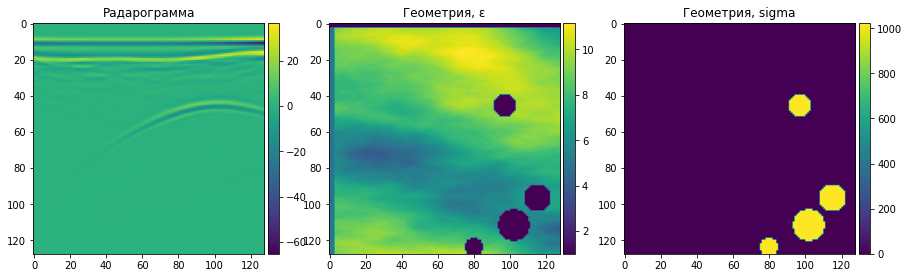

In [ ]:
with open(os.path.join(folder, 'data.pickle'), 'rb') as f:
    data_bscans, data_geometry = pickle.load(f)

visualizate_random_dataset_sample(data_bscans, data_geometry)

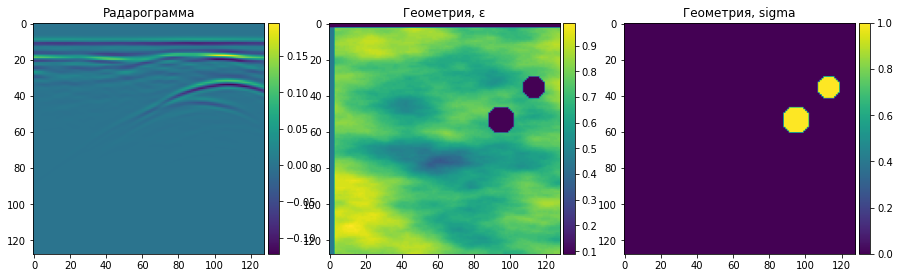

In [ ]:
data_bscans_scall = np.zeros_like(data_bscans)
data_bscans_scall[:,:,:,0], scall = normalization(data_bscans[:,:,:,0])

data_geometry_scall = np.zeros_like(data_geometry)
data_geometry_scall[:,:,:,0], geometry_eps_scaller = normalization(data_geometry[:,:,:,0])
data_geometry_scall[:,:,:,1], geometry_sigma_scaller = normalization(data_geometry[:,:,:,1])

visualizate_random_dataset_sample(data_bscans_scall, data_geometry_scall)

In [ ]:
x = np.concatenate((data_bscans_scall, data_geometry_scall[:,:,:,1:2]), axis = 3)
y = data_geometry_scall[:,:,:,0:1]
x.shape, y.shape

((1081, 128, 128, 2), (1081, 128, 128, 1))

In [ ]:
GEOM_CHANNELS = y_train.shape[3]
IMAGE_CHANNELS = X_train.shape[3]

## Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y,
    test_size=VAL_SPLIT, 
    random_state=42)
# visualizate_random_dataset_sample(X_test, y_test)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((972, 128, 128, 2),
 (109, 128, 128, 2),
 (972, 128, 128, 1),
 (109, 128, 128, 1))

## AE service functions

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, LeakyReLU, ReLU

# Создадим функцию сборки блока построения сверточного энкодера

def encoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейроной сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1,  # Число шагом сверточного слоя
                 batch_normalization = True,
                 activation = "relu",
):

    # Составим блок сети
    x = Conv2D(neu, kernel_size=kernel, strides=strides, padding='same', activation=activation)(xin) # Добавим 2D свертку
    if batch_normalization:
      x = BatchNormalization()(x)                                         # Добавим нормализацию по батчу
    # x = ReLU()(x)                                                         # Добавим функцию активации

    # Вернем выходной тензор
    return x

# Создадим функцию сборки блока построения сверточного декодера

def decoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейроной сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1,  # Число шагом сверточного слоя
                 batch_normalization = True,
                 activation = "relu",): 

    # Составим блок сети
    x = Conv2DTranspose(neu, kernel_size=kernel, strides= strides, padding='same',activation=activation)(xin)  # Добавим обратную 2D свертку
    if batch_normalization:
      x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
    # x = ReLU()(x)                                                                   # Добавим функцию активации

    # Вернем выходной тензор
    return x

def show_predict_random_sample(model, X, y,       # обученная модель
                   count = 1,     # количество случайных картинок для сегментации
                   ):
  
    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
  indexes = np.random.randint(0, len(X_test), count)

  bscans = X[indexes]
  orig_geom = y[indexes]
  # Вычисление предсказания сети для картинок с отобранными индексами
  predict = model.predict(bscans)
  # print(predict.min(), predict.max() )

  # Подготовка цветов классов для отрисовки предсказания

  fig, axs = plt.subplots(2, 3, figsize=(15, 10)) 
  for i in range(count):
      axs[0, 0].set_title('Bscan:')
      axs[0, 0].imshow(bscans[i][:,:,0])
      axs[0, 0].axis('off')

      axs[0, 1].set_title('Orig_geom, ε')
      # matshow(geom[:, :,0], cmap=cm.gray_r, norm=LogNorm(vmin=0.01, vmax=1))

      axs[0, 1].imshow(orig_geom[i][:,:,0])
      axs[0 ,1].axis('off')

      # axs[0, 2].set_title('Orig_geom, sigma')
      # axs[0, 2].imshow(orig_geom[i][:,:,1])
      # axs[0 ,2].axis('off')

      axs[1, 0].set_title('Add information:')
      axs[1, 0].imshow(bscans[i][:,:,0])
      axs[1, 0].axis('off')

      axs[1, 1].set_title('Pred_geom, ε')
      axs[1, 1].imshow(predict[i][:,:,0])
      axs[1 ,1].axis('off')

      # axs[1, 2].set_title('Pred_geom, sigma')
      # axs[1, 2].imshow(predict[i][:,:,1])
      # axs[1 ,2].axis('off')

  plt.show()

## Model CAE
просто подаем на вход геометрию проводимости. Очень большое переобучение

### Create and fit 

In [ ]:
# Функция сборки свёрточного автокодировщика
def create_base_ae(in_shape, geom_channels):

  # Входной слой 
  inputs = Input(in_shape)

  # Энкодер, 3 блока свертки перед сжатием 
  x = encoderBlock(inputs, 12, 3, 1)
  # используем разрежение (dilation_rate) для выявления мелких деталей изображения
  x = encoderBlock(x, 24, 3, 1)
  x = encoderBlock(x, 48, 3, 1)
  # Сжатие 1
  x = encoderBlock(x, 96, 3, 2)
  x = encoderBlock(x, 96, 3, 1)
  # Сжатие 2
  x = encoderBlock(x, 128, 3, 2)
  x = encoderBlock(x, 256, 3, 1, False)
  z = BatchNormalization()(x)
  
  # Декодер
  # ---------------------------------------------------------------
  # Расширение 2
  x = decoderBlock(z, 128, 3, 2,)
  x = decoderBlock(x, 128, 3, 1,)

  # Расширение 1
  x = decoderBlock(x, 96, 3, 2,)
  x = decoderBlock(x, 48, 3, 1,)

  x = decoderBlock(x, 24, 3, 1,)

  x = decoderBlock(x, 8, 3, 1,)

  # финальный слой свертки, выход модели
  outputs = Conv2D(geom_channels, 2, dilation_rate=2, padding='same', activation='sigmoid')(x)

  # Сборка модели. На входе оригинальное изображение, на выходе - сжатое-восстановленное
  model = Model(inputs, outputs)

  # компиляция модели
  model.compile(optimizer=Adam(1e-3),
                loss='mse',
                metrics = 'mae')

  return model

In [ ]:
model_ae = create_base_ae((IMG_WIDTH, IMG_HEIGHT, IMAGE_CHANNELS), GEOM_CHANNELS)
# utils.plot_model(model_ae, show_shapes=True, dpi=40)
model_ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 2)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 12)      228       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 12)     48        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 24)      2616      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 24)     96        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 48)      10416 

In [ ]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_mae', 
                                      factor=0.1, 
                                      patience=10, 
                                      verbose=0,
                                      min_lr=0.000000000000000001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'simple_cae'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True)



# model_ae.load_weights(checkpoint_filepath)

model_ae.compile(optimizer=Adam(1e-2),
                loss='mse',
                metrics = 'mae')

history = model_ae.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                            #  model_checkpoint_callback
                             ])

Epoch 1/100
31/31 [==============================] - 27s 436ms/step - loss: 0.0296 - mae: 0.1317 - val_loss: 0.4825 - val_mae: 0.6679 - lr: 0.0100
Epoch 2/100
31/31 [==============================] - 9s 278ms/step - loss: 0.0173 - mae: 0.1055 - val_loss: 0.4825 - val_mae: 0.6679 - lr: 0.0100
Epoch 3/100
31/31 [==============================] - 9s 282ms/step - loss: 0.0166 - mae: 0.1033 - val_loss: 0.4629 - val_mae: 0.6480 - lr: 0.0100
Epoch 4/100
31/31 [==============================] - 9s 286ms/step - loss: 0.0161 - mae: 0.1012 - val_loss: 0.0351 - val_mae: 0.1365 - lr: 0.0100
Epoch 5/100
31/31 [==============================] - 9s 288ms/step - loss: 0.0156 - mae: 0.0992 - val_loss: 0.0275 - val_mae: 0.1250 - lr: 0.0100
Epoch 6/100
31/31 [==============================] - 9s 287ms/step - loss: 0.0154 - mae: 0.0982 - val_loss: 0.0290 - val_mae: 0.1281 - lr: 0.0100
Epoch 7/100
31/31 [==============================] - 9s 284ms/step - loss: 0.0150 - mae: 0.0968 - val_loss: 0.0267 - val_ma

KeyboardInterrupt: ignored

## Model VAE

Смысл локализовать точки скрытого простанства с помощью изменения лосса, считаю что не очень подходит для такой задачи. В ОБУЧЕНИИ БЕСКОНЕЧНЫЙ ЛОСС

### Create and fit 

In [ ]:
# Подключим модуль вычислений на Keras
import keras.backend as K
# Импортируем Keras
import keras

HIDDEN_DIM = 2**1

# Создадим функцию - генератор случайных чисел с заданными параметрами

def noiser(args):                                                          # Входные параметры
  z_mean, z_log_var = args                                                 # Разберем входные параметры на отдельные переменные
  N = K.random_normal(shape=(K.shape(z_mean)[0], HIDDEN_DIM), mean=0., stddev=1.0) # Генерируем тензор из нормальных случайных  чисел с параметрами (0,1)

  # Вернем тензор случайных числел с заданной дисперсией и мат.ожиданием
  return K.exp(z_log_var / 2) * N + z_mean  # На выходе - тензор случайных чисел 

In [ ]:

inputs_enc = Input((IMG_WIDTH, IMG_HEIGHT, IMAGE_CHANNELS))

# Энкодер, 3 блока свертки перед сжатием 
x = encoderBlock(inputs_enc, 12, 3, 1)
# используем разрежение (dilation_rate) для выявления мелких деталей изображения
x = encoderBlock(x, 24, 3, 1)
x = encoderBlock(x, 48, 3, 1)
# Сжатие 1
x = encoderBlock(x, 96, 3, 2)
x = encoderBlock(x, 96, 3, 1)
# Сжатие 2
x = encoderBlock(x, 128, 3, 2)
x = encoderBlock(x, 256, 3, 1, False)
x = BatchNormalization()(x)
flatten =Flatten()(x)                                    # Добавим Flatten
x = Dense(HIDDEN_DIM, activation='linear')(flatten)               # Добавим выходной dense слой

z_mean = Dense(HIDDEN_DIM, name = 'z_mean')(x)        # Добавим dense для получения мат.ожидания
z_log_var = Dense(HIDDEN_DIM, name = 'z_log_var')(x)     # Добавим dense для получения логарифма дисперсии

# Создадим свой слой - лямбда. На входе мат.ожидание и логарифм дисперсии 
h = Lambda(noiser, output_shape=(HIDDEN_DIM,))([z_mean, z_log_var])        

encoderVAE = keras.Model(inputs_enc, [z_mean, z_log_var, h], name='encoder')



input_dec = Input(shape=(HIDDEN_DIM,))                      # Добавим входной слой
# Декодер
x = Dense(256*32*32, activation='linear')(input_dec)        # Добавим dense в 7х7х64 = 3136 нейронами #todo задать переменные
x = Reshape((32, 32, 256))(x)                               # Решейпим 1D тензор в 3D тензор
# ---------------------------------------------------------------
# Расширение 2
x = decoderBlock(x, 128, 3, 2,)
x = decoderBlock(x, 128, 3, 1,)

# Расширение 1
x = decoderBlock(x, 96, 3, 2,)
x = decoderBlock(x, 48, 3, 1,)

x = decoderBlock(x, 24, 3, 1,)

x = decoderBlock(x, 8, 3, 1,)

outputs = Conv2D(GEOM_CHANNELS, 2, dilation_rate=2, padding='same', activation='sigmoid', name = 'decoder_output')(x)

decoderVAE = keras.Model(input_dec, outputs)

outputs = decoderVAE(encoderVAE((inputs_enc))[2]) 

model_vae = keras.Model(inputs_enc, decoderVAE(encoderVAE((inputs_enc))[2])) # Соберем VAE
# encoderVAEС.summary()

reconstruction_loss = keras.losses.MSE(inputs_enc, outputs)     # Рассчитаем ошибку восстановления изображения - лоссы MSE
reconstruction_loss *= 128*128                                   # Уберем нормировку MSE
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)  # Рассчитаем лоссы KL
kl_loss = -0.5* K.sum(kl_loss, axis=-1)                        #  
vaeс_loss = K.mean(reconstruction_loss) +  K.mean(kl_loss)      # Суммируем лоссы - здесь можно вводить веса  
model_vae.add_loss(vaeс_loss)                                         # Отдадим наш лосс VAE
# model_vae.summary()

# model_vae.compile(
#              optimizer=Adam(1e-3),
#              ) # оптимайзер ADAM
model_vae.compile(optimizer='adam') # оптимайзер ADAM

In [ ]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_mae', 
                                      factor=0.1, 
                                      patience=10, 
                                      verbose=0,
                                      min_lr=0.000000000000000001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'simple_vae'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True)

history = model_vae.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                             model_checkpoint_callback
                             ])

Epoch 1/100
24/31 [======================>.......] - ETA: 2s - loss: nan

KeyboardInterrupt: ignored

# Задача 2. Повышение разрешения (дискретизации)
На вход подается разреженная радарограмма (128,128,1) с обнулением каждого второго профиля, на выход подается исходная геометрия (128,128,1).

## Giperparams

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 128, 128
VAL_SPLIT = 0.1
folder = 'drive/MyDrive/dataset_2/'
EPOCHS = 100

## Servise functions

In [ ]:
def load_bscans(folder, height, width): 
    bscans_x = []                       # Список для радарограмм
    bscans_y = []
    for bscan in os.listdir(folder):        # Перебор по именам файлов в папке
        # Добавление в список изображения в виде массива,
        # в заданных размерах и в оттенках серого
        if 'bscan_' in bscan:
            y = zoom(np.load(os.path.join(folder, bscan)), (1,0.25)).T
            # print(folder+'\\'+bscan)
            x = np.zeros_like(y)
            x[:,:] = 0.0
            x[::2, ::2] = y[::2, ::2]
            bscans_x.append(x)
            bscans_y.append(y)

    # Возврат массива-результата
    return np.expand_dims(np.array(bscans_x), axis=3), np.expand_dims(np.array(bscans_y), axis=3)


def visualizate_random_dataset_sample(x,y):
  rand = random.randint(1, len(x)-1)
  print(rand)
  bscan = x[rand]
  geom = y[rand]
  print(bscan.shape, geom.shape)


  fig, ax = plt.subplots(1, 2, figsize = (15,15))
  ax[0].imshow(bscan[::2, ::2, 0])
  ax[1].imshow(geom[:, :, 0])
  # ax[2].imshow(geom[:, :, 1])
  # ax[1].imshow(npy[:, :, 1])
  plt.show()



def normalization(dataset):

  max = np.abs(dataset).max()
  min = dataset.min()
#   dataset = (dataset -min)/(max - min)
  dataset = (dataset)/(max)
  def transform(x, max = max, min=min):
    return x*(max-min)+min
  return dataset, transform



def show_predict_random_sample(model, X, y,       # обученная модель
                   count = 3,     # количество случайных картинок для сегментации
                   ):
  
    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
  indexes = np.random.randint(0, len(X), count)

  bscans = X[indexes]
  orig_geom = y[indexes]
  # Вычисление предсказания сети для картинок с отобранными индексами
  predict = model.predict(bscans)
  # print(predict.min(), predict.max() )

  # Подготовка цветов классов для отрисовки предсказания

  fig, axs = plt.subplots(count, 3, figsize=(25, 15)) 
  for i in range(count):
      # Отображение на графике в первой линии предсказания модели
      axs[0, 0].set_title('Bscan:')
      axs[i, 0].imshow(bscans[i][:,:,0])
      axs[i, 0].axis('off')

      # Отображение на графике во второй линии сегментированного изображения из y_val
      axs[0, 1].set_title('Orig_geom')
      axs[i, 1].imshow(orig_geom[i][:,:,0])
      axs[i ,1].axis('off')

      # Отображение на графике в третьей линии оригинального изображения
      axs[0, 2].set_title('Pred_geom')
      axs[i, 2].imshow(predict[i][:,:,0])
      axs[i ,2].axis('off')

  plt.show() 

  # return bscans, predict

## Обработка и визуализация датасета

Время загрузки: 150 с.
Размер bscans_x: (1081, 128, 128, 1); размер bscans_y(1081, 128, 128, 1)
886
(128, 128, 1) (128, 128, 1)


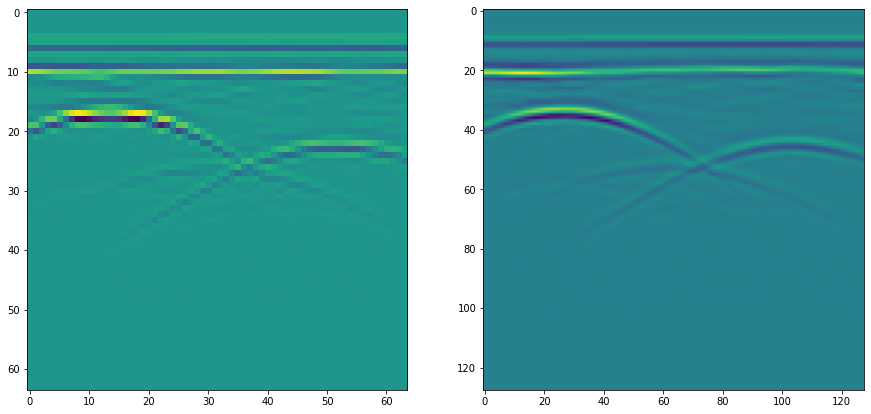

In [ ]:
cur_time = time.time()
bscans_x, bscans_y = load_bscans(folder, IMG_HEIGHT, IMG_WIDTH)

print(f'Время загрузки: {round(time.time()-cur_time)} с.')
print(f'Размер bscans_x: {bscans_x.shape}; размер bscans_y{bscans_y.shape}')

visualizate_random_dataset_sample(bscans_x, bscans_y)

1080
(128, 128, 1) (128, 128, 1)


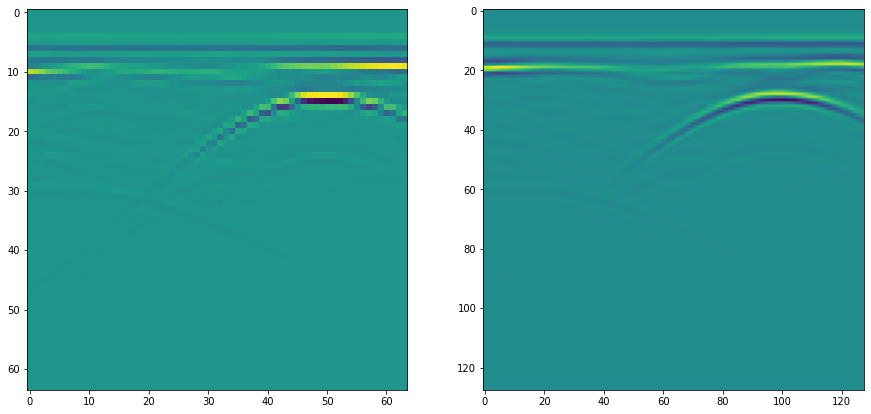

In [ ]:
bscans_x_scall, bscans_x_scaller = normalization(bscans_x)
bscans_y_scall, bscans_y_scaller = normalization(bscans_y)



visualizate_random_dataset_sample(bscans_x_scall, bscans_y_scall)

52
(128, 128, 1) (128, 128, 1)


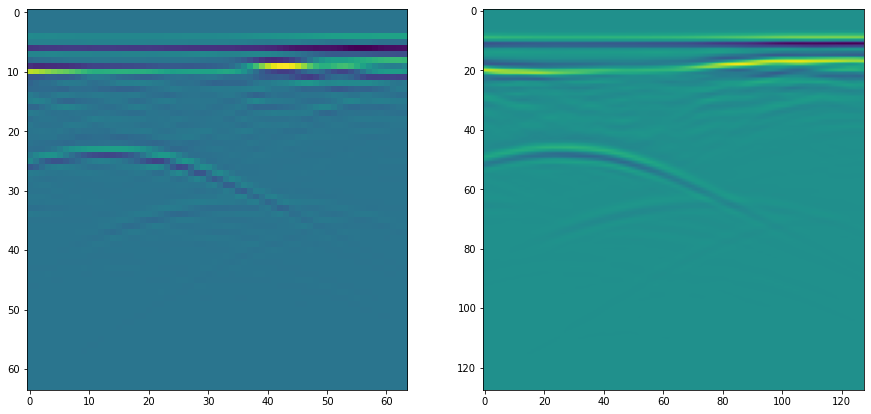

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    bscans_x_scall, 
    bscans_y_scall,
    test_size=VAL_SPLIT, 
    random_state=42)

visualizate_random_dataset_sample(X_test, y_test)

## Model sunet

### Create and fit 

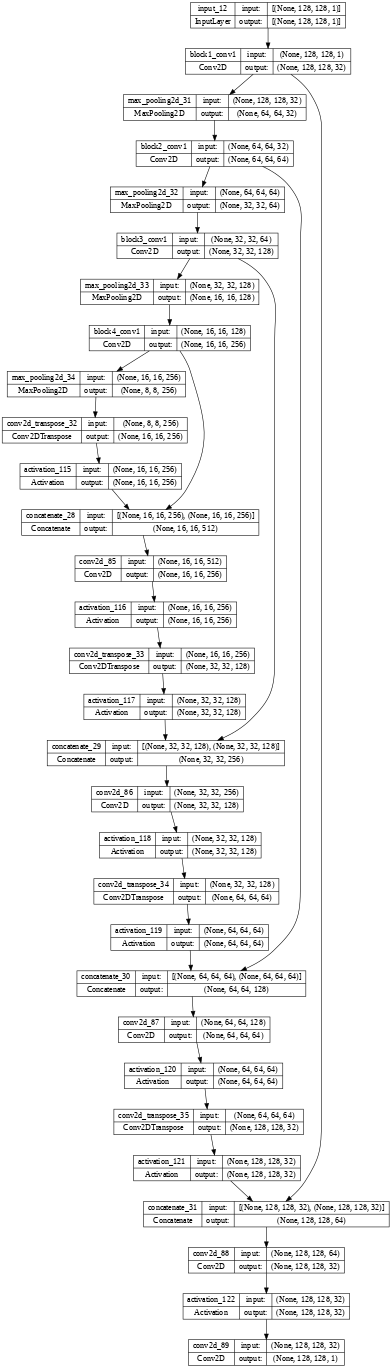

In [ ]:
def sunet(input_shape,
          class_count, inter_activation):
  img_input = Input(input_shape)   

  ''' Block 1 '''
  block_1_out = Conv2D(32, (12, 12), padding='same', name='block1_conv1', activation = inter_activation)(img_input)
  x = MaxPooling2D()(block_1_out) 

  # ''' Block 2 '''
  block_2_out = Conv2D(64, (5,5), padding='same', name='block2_conv1', activation = inter_activation)(x)
  x = MaxPooling2D()(block_2_out) 

  # ''' Block 3 '''
  block_3_out = Conv2D(128, (3,3), padding='same', name='block3_conv1', activation = inter_activation)(x)
  x = MaxPooling2D()(block_3_out)

  # ''' Block 4 '''
  block_4_out = Conv2D(256, (3,3), padding='same', name='block4_conv1', activation = inter_activation)(x)
  x = MaxPooling2D()(block_4_out)

  # ''' UP 1 '''
  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation(inter_activation)(x)

  x = concatenate([x, block_4_out])
  x = Conv2D(256, (3, 3), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation(inter_activation)(x)

  # x = Conv2D(128, (3,3), padding='same', activation = 'relu')(x)

  # ''' UP 2 '''
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation(inter_activation)(x)

  x = concatenate([x, block_3_out])
  x = Conv2D(128, (3, 3), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation(inter_activation)(x)  

  # ''' UP 3 '''
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation(inter_activation)(x)

  x = concatenate([x, block_2_out])
  x = Conv2D(64, (5, 5), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation(inter_activation)(x) 


  # ''' UP 4 '''
  x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation(inter_activation)(x)

  x = concatenate([x, block_1_out])
  x = Conv2D(32, (12, 12), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation(inter_activation)(x) 

  x = Conv2D(class_count, (3, 3), padding='same', activation = 'linear')(x)




  model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

  # Компилируем модель
  model.compile(optimizer=Adam(learning_rate=1e-3),
                loss='mse',
                metrics=['mae'])

  # Возвращаем сформированную модель
  return model

model_sunet = sunet((IMG_WIDTH, IMG_HEIGHT, 1), class_count = 1, inter_activation = 'linear')
# utils.plot_model(model_sunet, show_shapes=True, dpi=40)

In [ ]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.1, 
                                      patience=2, 
                                      verbose=1,
                                      min_lr=0.000000001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'sunet_geometry'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=True)

history = model_sunet.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True,
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                            #  model_checkpoint_callback
                             ],
                          )

Epoch 1/100
31/31 [==============================] - 6s 176ms/step - loss: 3.0830e-04 - mae: 0.0085 - val_loss: 2.0855e-04 - val_mae: 0.0047 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - 5s 166ms/step - loss: 1.3063e-04 - mae: 0.0037 - val_loss: 1.4424e-04 - val_mae: 0.0036 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 1.0149e-04 - mae: 0.0027
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
31/31 [==============================] - 5s 167ms/step - loss: 1.0149e-04 - mae: 0.0027 - val_loss: 1.2470e-04 - val_mae: 0.0028 - lr: 0.0010
Epoch 4/100
31/31 [==============================] - 5s 167ms/step - loss: 8.4159e-05 - mae: 0.0023 - val_loss: 1.1290e-04 - val_mae: 0.0023 - lr: 1.0000e-04
Epoch 5/100
31/31 [==============================] - 5s 165ms/step - loss: 7.8316e-05 - mae: 0.0022 - val_loss: 1.0854e-04 - val_mae: 0.0023 - lr: 1.0000e-04
Epoch 6/100
31/31 [==============================] - 5s 168ms/s

KeyboardInterrupt: ignored

### Visualizate

1/1 [==============================] - 0s 18ms/step


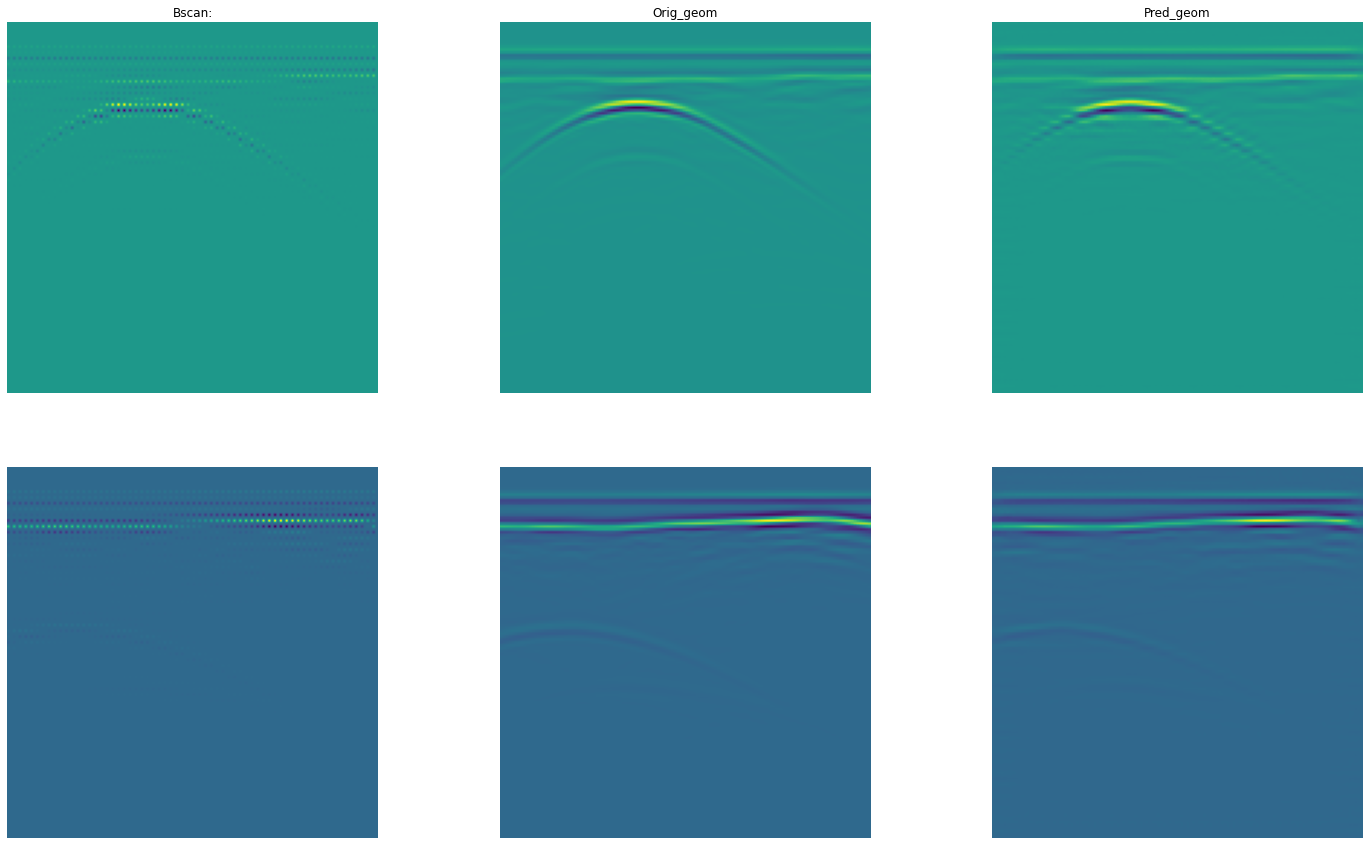

In [ ]:
 _, _ = show_predict_random_sample(model_sunet, X_test, y_test,count = 2,)

## Model unet

### Create and fit 

In [ ]:
def unet(input_shape,
          class_count):
  img_input = Input(input_shape)   

  ''' Block 1 '''
  block_1_out = Conv2D(32, (15, 15), padding='same', name='block1_conv1', activation = 'relu')(img_input)
  x = MaxPooling2D()(block_1_out) 

  # ''' Block 2 '''
  block_2_out = Conv2D(64, (5,5), padding='same', name='block2_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_2_out) 

  # ''' Block 3 '''
  block_3_out = Conv2D(128, (3,3), padding='same', name='block3_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_3_out)

  # ''' Block 4 '''
  block_4_out = Conv2D(256, (3,3), padding='same', name='block4_conv1', activation = 'relu')(x)
  x = MaxPooling2D()(block_4_out)

  # ''' UP 1 '''
  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_4_out])
  x = Conv2D(256, (3, 3), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # x = Conv2D(128, (3,3), padding='same', activation = 'relu')(x)

  # ''' UP 2 '''
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_3_out])
  x = Conv2D(128, (3, 3), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x)  

  # ''' UP 3 '''
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_2_out])
  x = Conv2D(64, (5, 5), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x) 


  # ''' UP 4 '''
  x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)
  # # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_1_out])
  x = Conv2D(32, (12, 12), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x) 

  x = Conv2D(class_count, (3, 3), padding='same', activation = 'linear')(x)

  model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

  # Компилируем модель
  model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='mse',
                metrics=['mae'])

  # Возвращаем сформированную модель
  return model

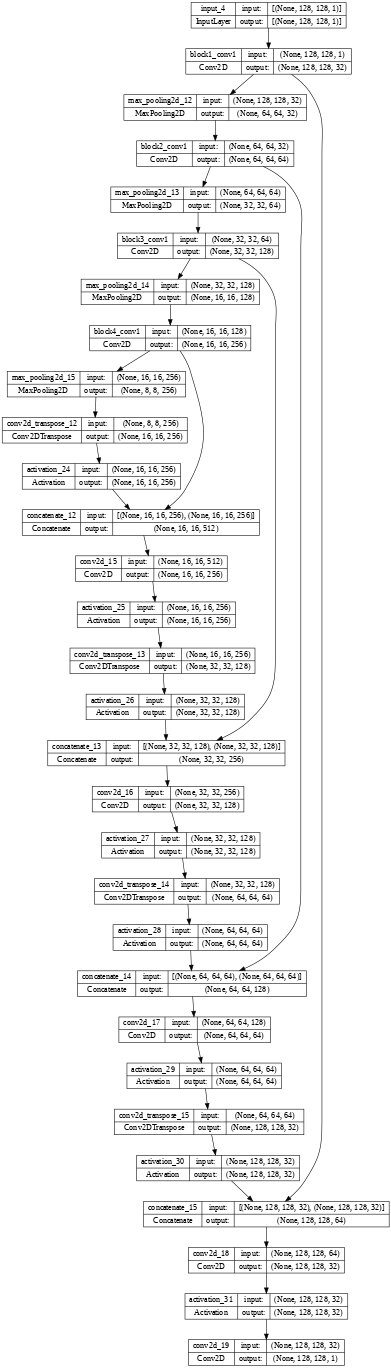

In [ ]:
model_unet = unet((IMG_WIDTH, IMG_HEIGHT, 1), 1)
utils.plot_model(model_unet, show_shapes=True, dpi=40)

In [ ]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='mae', 
                                      factor=0.1, 
                                      patience=2, 
                                      verbose=0,
                                      min_lr=0.0000000001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'unet_geometry'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=True)

# model_unet.compile(optimizer=Adam(learning_rate=1e-6))

history = model_unet.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                            #  model_checkpoint_callback
                         ],
                         )

Epoch 1/100
31/31 [==============================] - 7s 187ms/step - loss: 4.8198e-04 - mae: 0.0065 - val_loss: 3.2514e-04 - val_mae: 0.0058 - lr: 1.0000e-04
Epoch 2/100
31/31 [==============================] - 5s 173ms/step - loss: 2.2438e-04 - mae: 0.0048 - val_loss: 2.5521e-04 - val_mae: 0.0043 - lr: 1.0000e-04
Epoch 3/100
31/31 [==============================] - 5s 175ms/step - loss: 1.8050e-04 - mae: 0.0039 - val_loss: 2.2461e-04 - val_mae: 0.0038 - lr: 1.0000e-04
Epoch 4/100
31/31 [==============================] - 5s 175ms/step - loss: 1.6105e-04 - mae: 0.0035 - val_loss: 2.0480e-04 - val_mae: 0.0034 - lr: 1.0000e-04
Epoch 5/100
31/31 [==============================] - 5s 172ms/step - loss: 1.4148e-04 - mae: 0.0034 - val_loss: 1.7862e-04 - val_mae: 0.0037 - lr: 1.0000e-04
Epoch 6/100
31/31 [==============================] - 5s 171ms/step - loss: 1.2255e-04 - mae: 0.0032 - val_loss: 1.5218e-04 - val_mae: 0.0033 - lr: 1.0000e-04
Epoch 7/100
31/31 [==============================] -

KeyboardInterrupt: ignored

### Visualizate

1/1 [==============================] - 0s 17ms/step


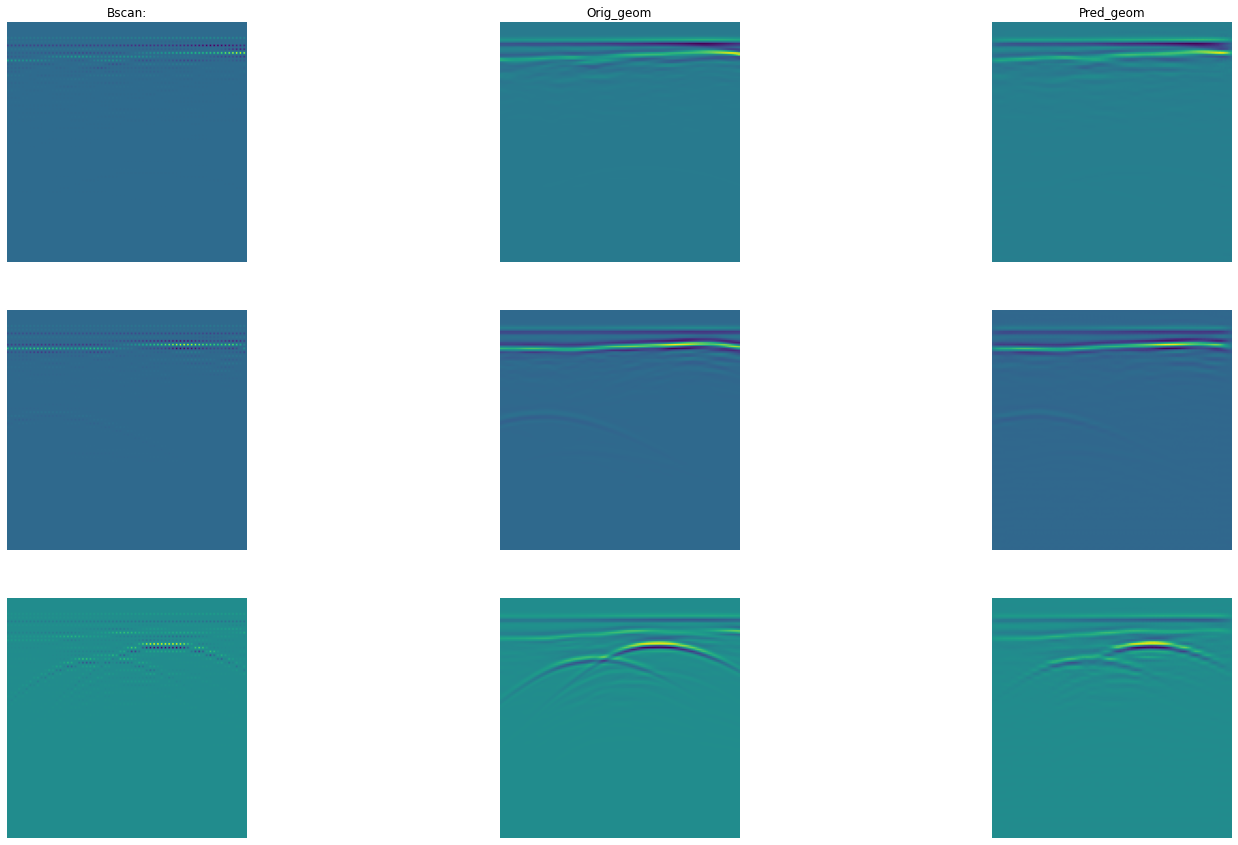

In [ ]:
_, _ = show_predict_random_sample(model_unet, X_test, y_test)

## Model AE

### Create and fit 

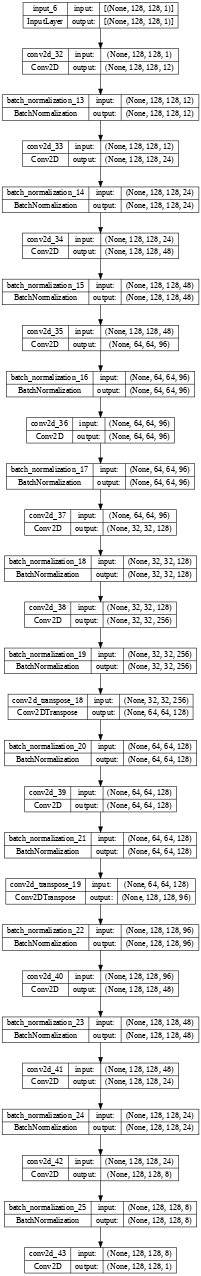

In [ ]:
# Функция сборки свёрточного автокодировщика
def create_base_ae(in_shape, geom_channels):

  # Входной слой 
  inputs = Input(in_shape)

  # Энкодер
  # ---------------------------------------------------------------

  # 3 блока свертки перед сжатием 
  x = Conv2D(12, 3, padding='same', activation='relu')(inputs)
  x = BatchNormalization()(x)

  # используем разрежение (dilation_rate) для выявления мелких деталей изображения
  x = Conv2D(24, 3, dilation_rate=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 1
  x = Conv2D(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(96, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 2
  x = Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(256, 3, padding='same', activation='relu')(x)

  # Скрытое пространство
  z = BatchNormalization()(x)

  # Декодер
  # ---------------------------------------------------------------
  # Расширение 2
  x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(z)
  x = BatchNormalization()(x)

  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Расширение 1
  x = Conv2DTranspose(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(24, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(8, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # финальный слой свертки, выход модели
  outputs = Conv2D(geom_channels, 2, dilation_rate=2, padding='same', activation='linear')(x)

  # Сборка модели. На входе оригинальное изображение, на выходе - сжатое-восстановленное
  model = Model(inputs, outputs)

  # компиляция модели
  model.compile(optimizer=Adam(1e-4),
                loss='mse',
                metrics = 'mae')

  return model
  
model_ae = create_base_ae((IMG_WIDTH, IMG_HEIGHT, 1), 1)
utils.plot_model(model_ae, show_shapes=True, dpi=40)

In [ ]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='loss', 
                                      factor=0.1, 
                                      patience=2, 
                                      verbose=1,
                                      min_lr=0.000000001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'base_ae_geometry'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=True)

model_ae.compile(optimizer=Adam(1e-6),
                loss='mse',
                metrics = 'mae')

history = model_ae.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                            #  model_checkpoint_callback
                             ])

Epoch 1/100
31/31 [==============================] - 11s 305ms/step - loss: 0.0015 - mae: 0.0202 - val_loss: 0.0018 - val_mae: 0.0180 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 9s 298ms/step - loss: 0.0015 - mae: 0.0199 - val_loss: 0.0017 - val_mae: 0.0180 - lr: 1.0000e-06
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0196
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
31/31 [==============================] - 9s 299ms/step - loss: 0.0014 - mae: 0.0196 - val_loss: 0.0017 - val_mae: 0.0188 - lr: 1.0000e-06
Epoch 4/100
31/31 [==============================] - 9s 299ms/step - loss: 0.0014 - mae: 0.0198 - val_loss: 0.0019 - val_mae: 0.0243 - lr: 1.0000e-07
Epoch 5/100
 9/31 [=======>......................] - ETA: 6s - loss: 0.0014 - mae: 0.0197

KeyboardInterrupt: ignored

### Visualizate

1/1 [==============================] - 1s 1s/step


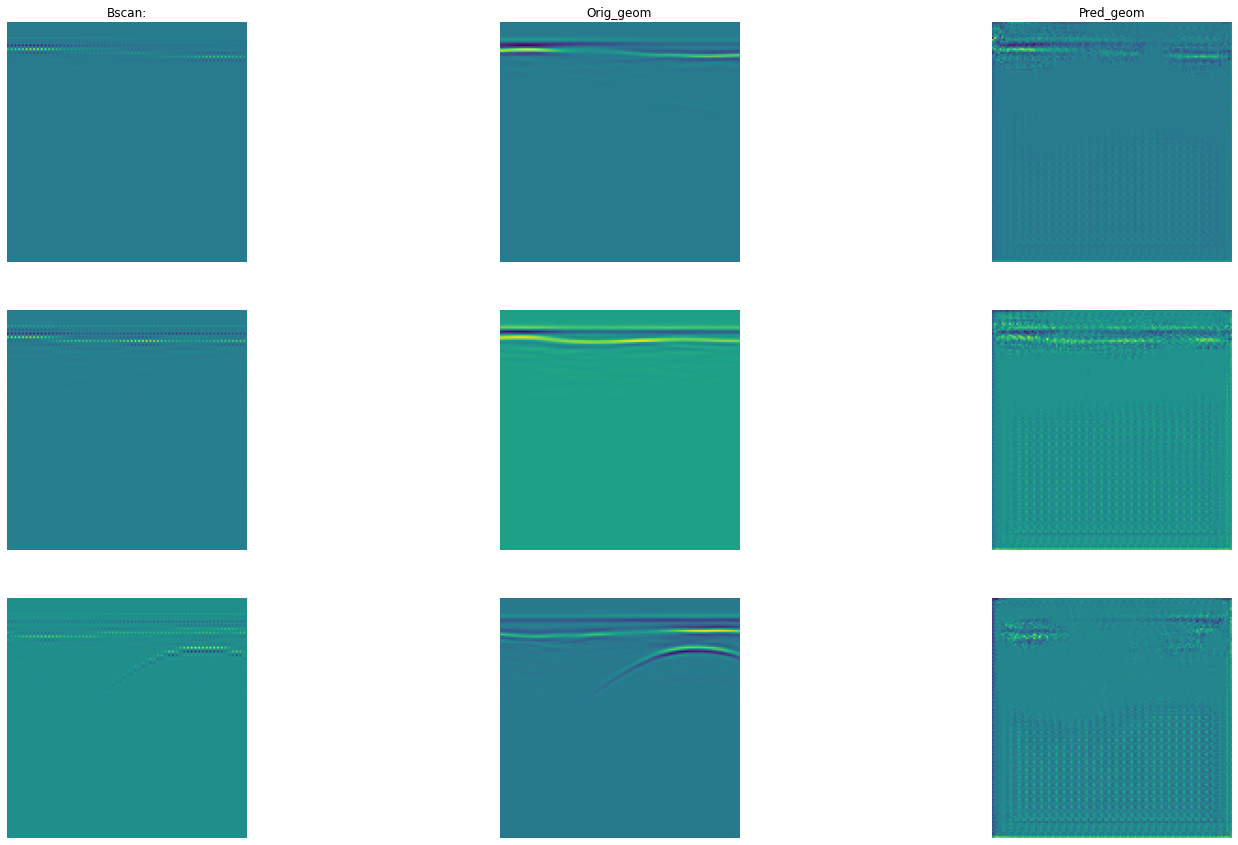

In [ ]:
 _,_ = show_predict_random_sample(model_ae, X_test, y_test)

## Model sequential_segmentation_net

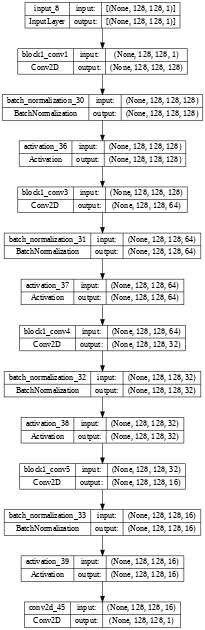

In [ ]:
def sequential_segmentation_net(class_count,  # количество классов
                                input_shape   # форма входного изображения
                                ):

    img_input = Input(input_shape)                                              # Создаем входной слой формой input_shape
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)   

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv3')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv4')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)     

    x = Conv2D(16, (3, 3), padding='same', name='block1_conv5')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)           
       
    x = Conv2D(class_count, (3, 3), activation='linear', padding='same')(x)    # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                                 # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='mse',
                  metrics=['mae'],
                  )
    
    # Возвращаем сформированную модель
    return model 

# Создание модели и вывод сводки по архитектуре

model_seq = sequential_segmentation_net(input_shape = (IMG_WIDTH, IMG_HEIGHT, 1), class_count = 1,)

# model_seq.summary()
utils.plot_model(model_seq, show_shapes=True, dpi=40)


In [ ]:
# Обучение модели

reduceLROnPlateau = ReduceLROnPlateau(monitor='mae', 
                                      factor=0.1, 
                                      patience=2, 
                                      verbose=0,
                                      min_lr=0.0000000001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'seg_geometry'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='mae',
    mode='max',
    save_best_only=True)

history = model_seq.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                            #  model_checkpoint_callback
                             ],
                        )

Epoch 1/100
31/31 [==============================] - 8s 174ms/step - loss: 0.6674 - mae: 0.2917 - val_loss: 0.0014 - val_mae: 0.0262 - lr: 1.0000e-05
Epoch 2/100
31/31 [==============================] - 4s 121ms/step - loss: 0.2498 - mae: 0.2492 - val_loss: 0.0028 - val_mae: 0.0459 - lr: 1.0000e-05
Epoch 3/100
31/31 [==============================] - 4s 121ms/step - loss: 0.1221 - mae: 0.2212 - val_loss: 0.0060 - val_mae: 0.0729 - lr: 1.0000e-05
Epoch 4/100
31/31 [==============================] - 4s 122ms/step - loss: 0.0853 - mae: 0.1945 - val_loss: 0.0119 - val_mae: 0.1058 - lr: 1.0000e-05
Epoch 5/100
31/31 [==============================] - 4s 122ms/step - loss: 0.0656 - mae: 0.1729 - val_loss: 0.0200 - val_mae: 0.1387 - lr: 1.0000e-05
Epoch 6/100
31/31 [==============================] - 4s 121ms/step - loss: 0.0530 - mae: 0.1542 - val_loss: 0.0269 - val_mae: 0.1613 - lr: 1.0000e-05
Epoch 7/100
31/31 [==============================] - 4s 119ms/step - loss: 0.0443 - mae: 0.1393 - va

KeyboardInterrupt: ignored

### Visualizate

1/1 [==============================] - 0s 358ms/step


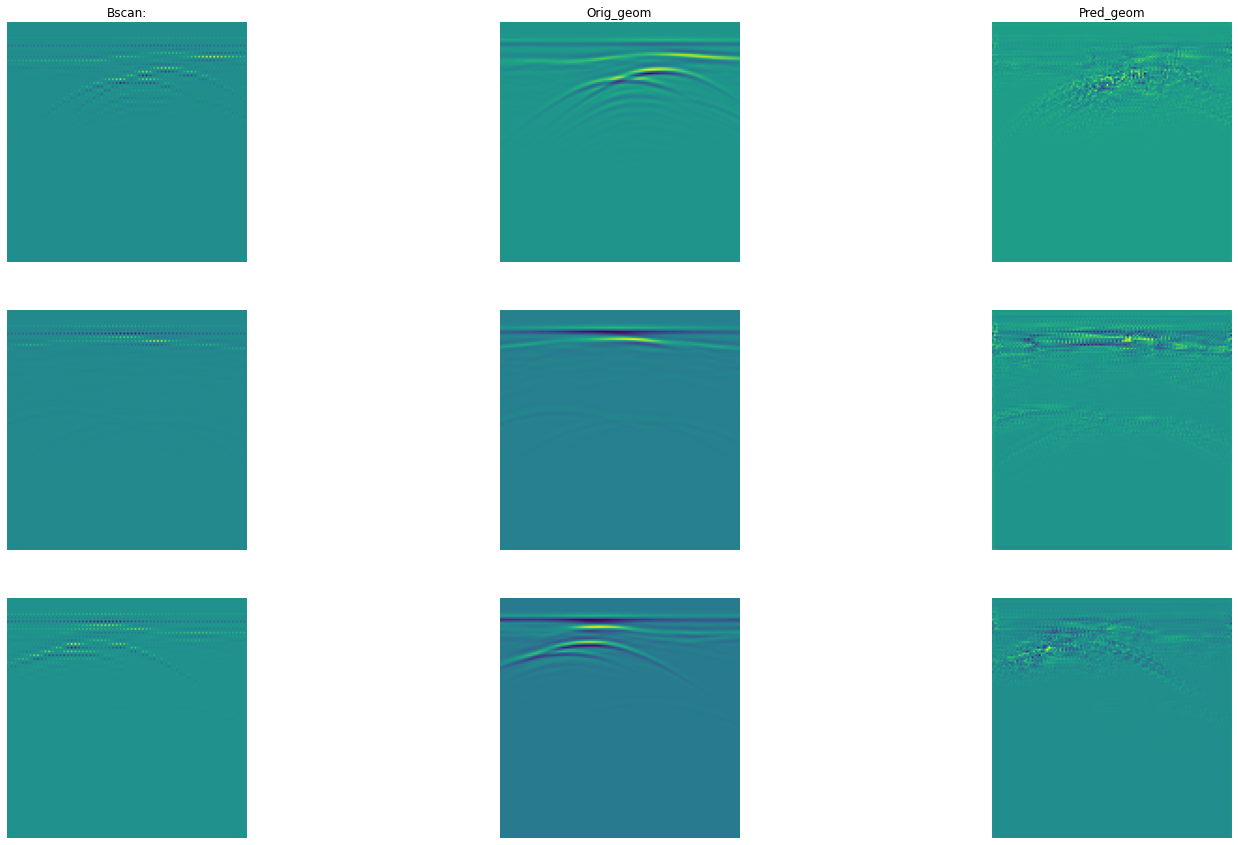

(array([[[[-1.38699650e-32],
          [ 0.00000000e+00],
          [ 1.98671550e-33],
          ...,
          [ 0.00000000e+00],
          [-4.68671222e-32],
          [ 0.00000000e+00]],
 
         [[ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          ...,
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00]],
 
         [[ 6.79045073e-15],
          [ 0.00000000e+00],
          [ 6.48694720e-15],
          ...,
          [ 0.00000000e+00],
          [ 1.03943270e-14],
          [ 0.00000000e+00]],
 
         ...,
 
         [[ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          ...,
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00]],
 
         [[-4.11907074e-07],
          [ 0.00000000e+00],
          [ 2.10114326e-07],
          ...,
          [ 0.00000000e+00],
          [-5.27374384e-08],
          [ 0.00000000e+00]],
 
         [[ 0.00000000e+

In [ ]:
 show_predict_random_sample(model_seq, X_test, y_test)

## Расширенная архитектура U-net


In [ ]:
def masked_unet(class_count,  # количество классов
                input_shape   # форма входного изображения
                ):
  
    img_input = Input(input_shape)                                              # Создаем входной слой формой input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv2D(64, (1, 1), padding='same')(block_1_out)          # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out)                                             # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)             # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)             # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(128, (1, 1), padding='same')(block_2_out)         # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling2D()(block_2_out)                                             # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(256, (1, 1), padding='same')(block_3_out)         # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling2D()(block_3_out)                                             # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(512, (1, 1), padding='same')(block_4_out)         # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling2D()(block_4_out)                                             # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling2D()(x)                                   # Добавляем слой MaxPooling2D
 
    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)         # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                         # Объединяем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(512, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)         # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                         # Объединяем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(256, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)         # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                         # Объединяем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(128, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)          # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                         # Объединяем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(64, (3, 3), padding='same')(x)                                   # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                                   # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='linear', padding='same')(x)    # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                                 # Создаем модель с входом 'img_input' и выходом 'x'
    
    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mae'])
    
    # Возвращаем сформированную модель
    return model

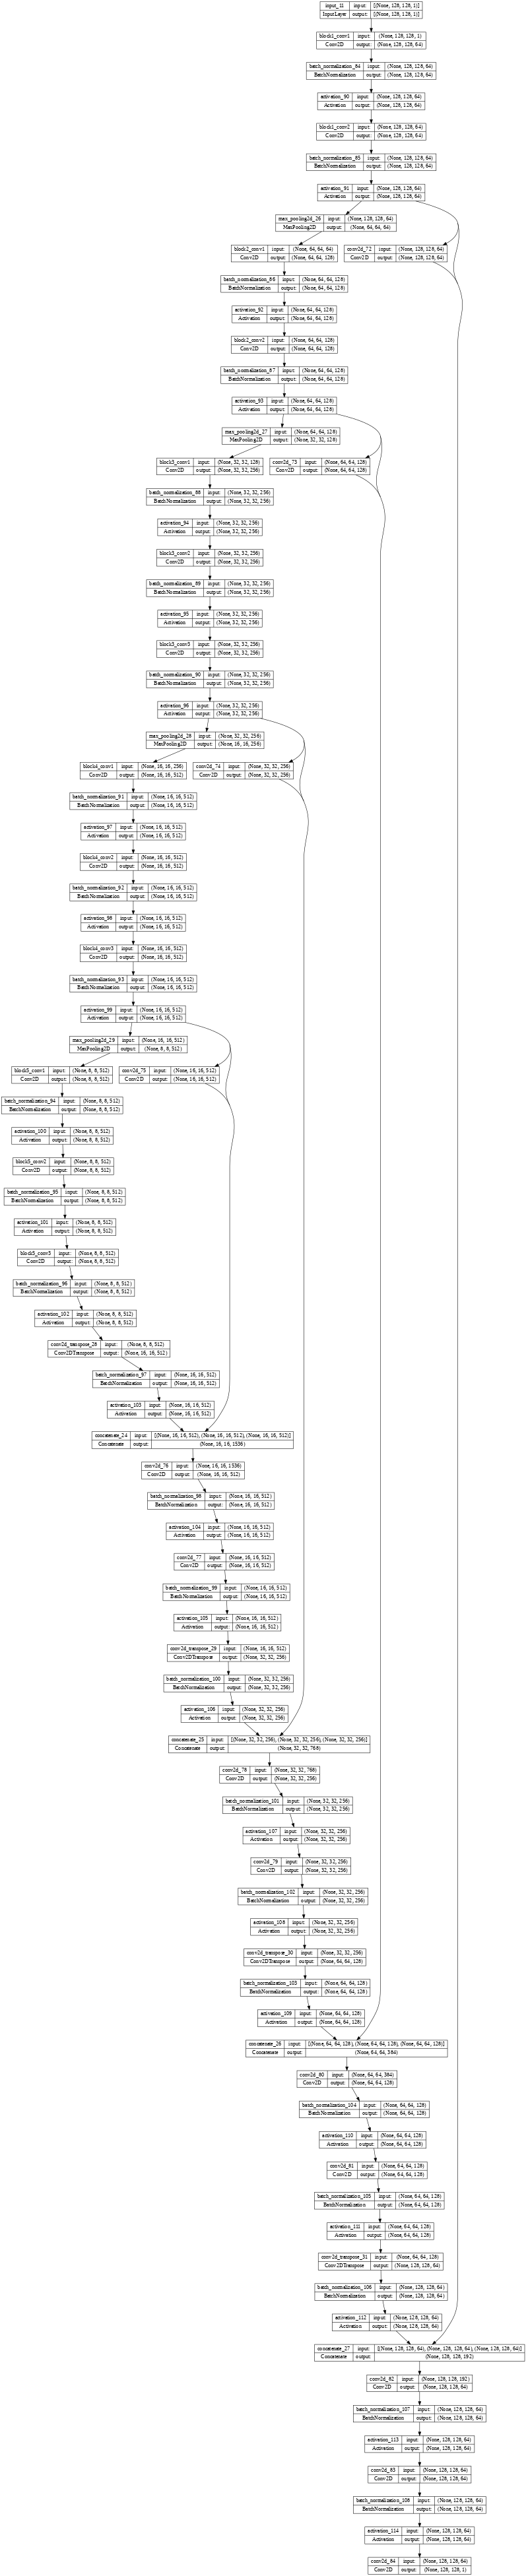

In [ ]:
model_masked_unet = masked_unet(1, (IMG_WIDTH, IMG_HEIGHT, 1), )
utils.plot_model(model_masked_unet, show_shapes=True, dpi=40)

In [ ]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.1, 
                                      patience=1, 
                                      verbose=0,
                                      min_lr=0.000000000000001)
earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

checkpoint_filepath = folder + 'base_masked_unet_geometry'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=True)

# Компилируем модель
model_masked_unet.compile(optimizer=Adam(learning_rate=1e-4),
              loss='mse',
              metrics=['mae'])


history = model_masked_unet.fit(X_train, y_train,
                         epochs=EPOCHS, 
                         validation_data=(X_test, y_test),
                         verbose=1, 
                         shuffle=True, 
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                            #  model_checkpoint_callback
                             ])

Epoch 1/100
31/31 [==============================] - 41s 870ms/step - loss: 0.1515 - mae: 0.1580 - val_loss: 0.0047 - val_mae: 0.0635 - lr: 1.0000e-04
Epoch 2/100
31/31 [==============================] - 21s 684ms/step - loss: 0.0072 - mae: 0.0438 - val_loss: 0.0063 - val_mae: 0.0745 - lr: 1.0000e-04
Epoch 3/100
31/31 [==============================] - 21s 681ms/step - loss: 0.0048 - mae: 0.0353 - val_loss: 0.0056 - val_mae: 0.0680 - lr: 1.0000e-05
Epoch 4/100
31/31 [==============================] - 21s 688ms/step - loss: 0.0047 - mae: 0.0348 - val_loss: 0.0052 - val_mae: 0.0642 - lr: 1.0000e-06
Epoch 5/100
31/31 [==============================] - 22s 695ms/step - loss: 0.0047 - mae: 0.0345 - val_loss: 0.0050 - val_mae: 0.0620 - lr: 1.0000e-07
Epoch 6/100
31/31 [==============================] - 21s 688ms/step - loss: 0.0046 - mae: 0.0345 - val_loss: 0.0049 - val_mae: 0.0606 - lr: 1.0000e-08
Epoch 7/100
31/31 [==============================] - 21s 684ms/step - loss: 0.0047 - mae: 0.03

KeyboardInterrupt: ignored

### Visualizate

1/1 [==============================] - 2s 2s/step


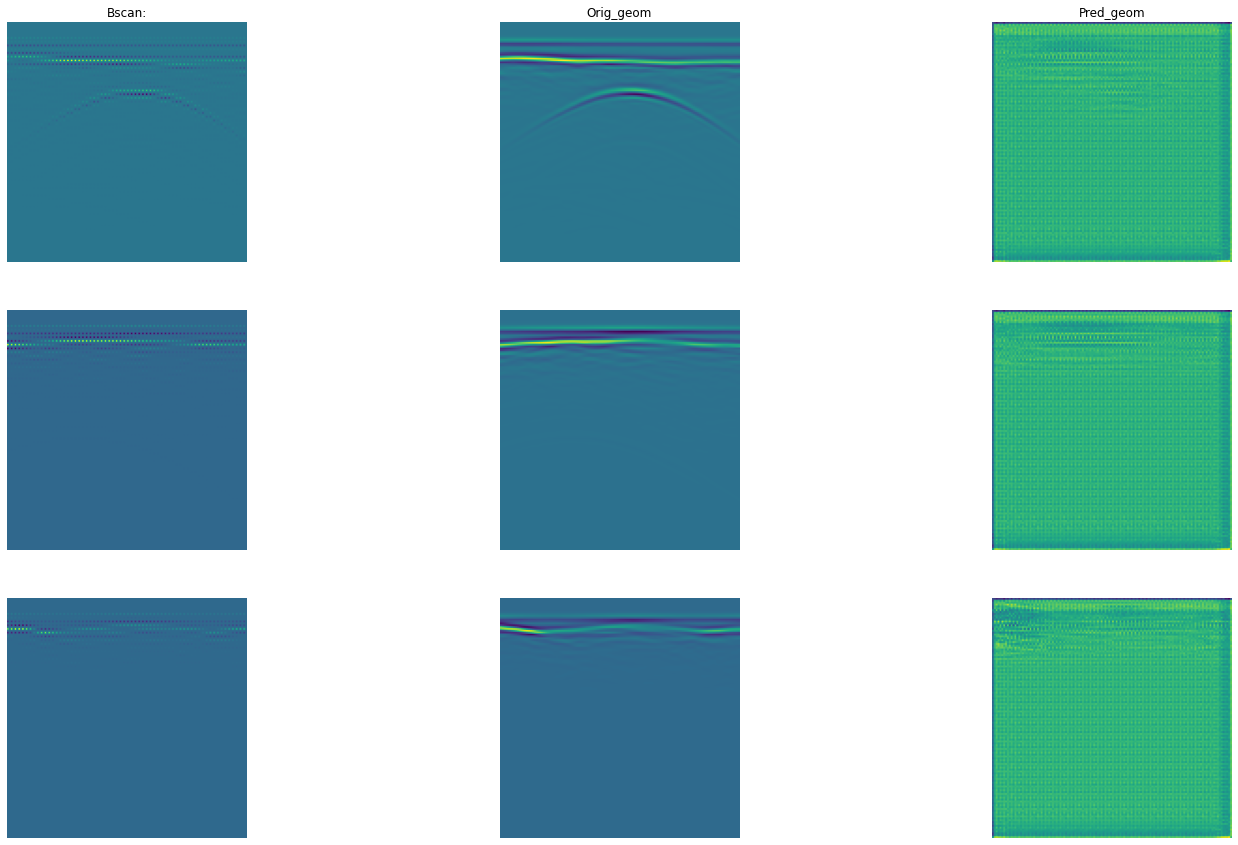

In [ ]:
 _, _ = show_predict_random_sample(model_masked_unet, X_test, y_test)

# Task 3. deconvolution. Ну тут провал

## Giperparams

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 512, 128
VAL_SPLIT = 0.1
folder = 'drive/MyDrive/dataset/'
EPOCHS = 100
datalen = 1

## Servise functions

In [ ]:
 def load_bscans_like_ascans(folder): 
    bscans_list = []                       # Список для радарограмм
    geometry_list = []
    
    for bscan in os.listdir(folder):        # Перебор по именам файлов в папке
        # Добавление в список изображения в виде массива,
        # в заданных размерах и в оттенках серого
        if 'bscan_' in bscan:
            bscans_list.append(np.load(os.path.join(folder, bscan)))
            # print(folder+'\\'+bscan)
            
    # делаем решейп            
    bscans_array = np.array(bscans_list)
    
    bscans_array = bscans_array.reshape([bscans_array.shape[0] * bscans_array.shape[1], 
                                   bscans_array.shape[2], 
                                   1])
    
    # Возврат массива-результата
    return bscans_array

def visualizate_random_dataset_ascan_sample(x, time_of_record_ns = 30, cound_samples =3):
  rand = [random.randint(0, len(x)-1) for i in range(3)]
  ascans = x[rand]
  dt =  time_of_record_ns/len(ascans[0])
  y = np.arange(0, time_of_record_ns, dt)
  fig, ax = plt.subplots(cound_samples, 1, figsize = (15,15))
  for i in range(cound_samples):
    ax[i].plot(ascans[i])

  plt.show()

def normalization(dataset):

  max = dataset.max()
  min = dataset.min()
  dataset = (dataset -min)/(max - min)
  def transform(x, max = max, min=min):
    return x*(max-min)+min
  return dataset, transform

def normalization2(dataset):

  max = np.abs(dataset).max()
  min = dataset.min()
#   dataset = (dataset -min)/(max - min)
  dataset = (dataset)/(max)
  def transform(x, max = max, min=min):
    return x*(max-min)+min
  return dataset, transform

## Обработка и визуализация датасета

Время загрузки: 231 с.
Размер bscans_y(201344, 512, 1)


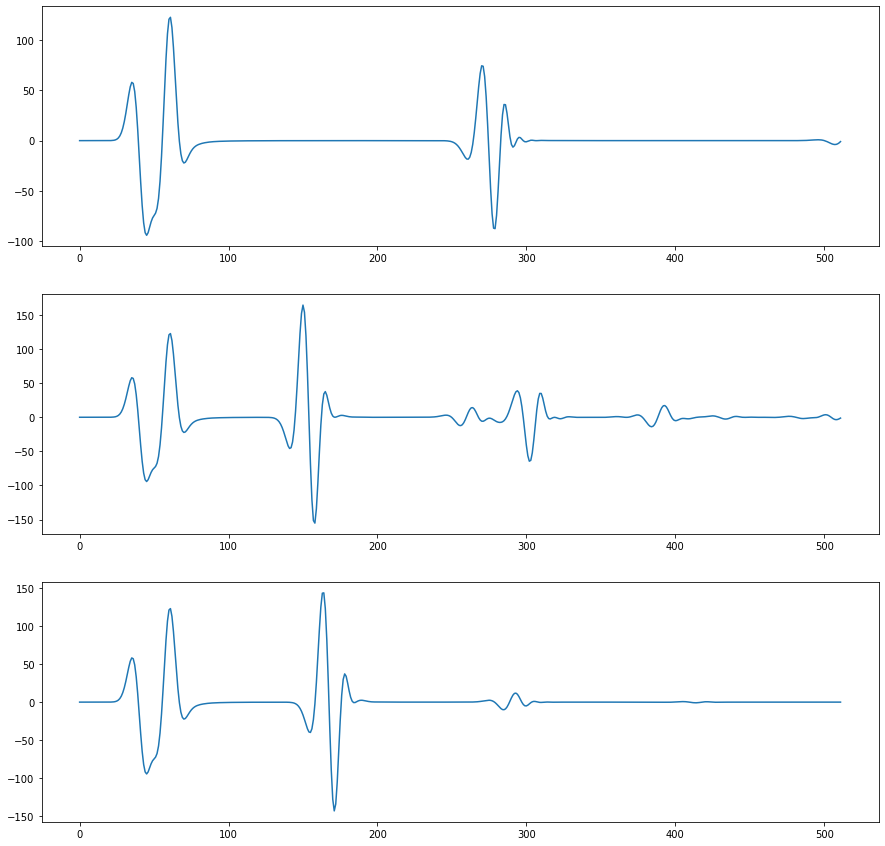

In [ ]:
cur_time = time.time()
data_ascans = load_bscans_like_ascans(folder)

print(f'Время загрузки: {round(time.time()-cur_time)} с.')
print(f'Размер bscans_y{data_ascans.shape}')


visualizate_random_dataset_ascan_sample(data_ascans)

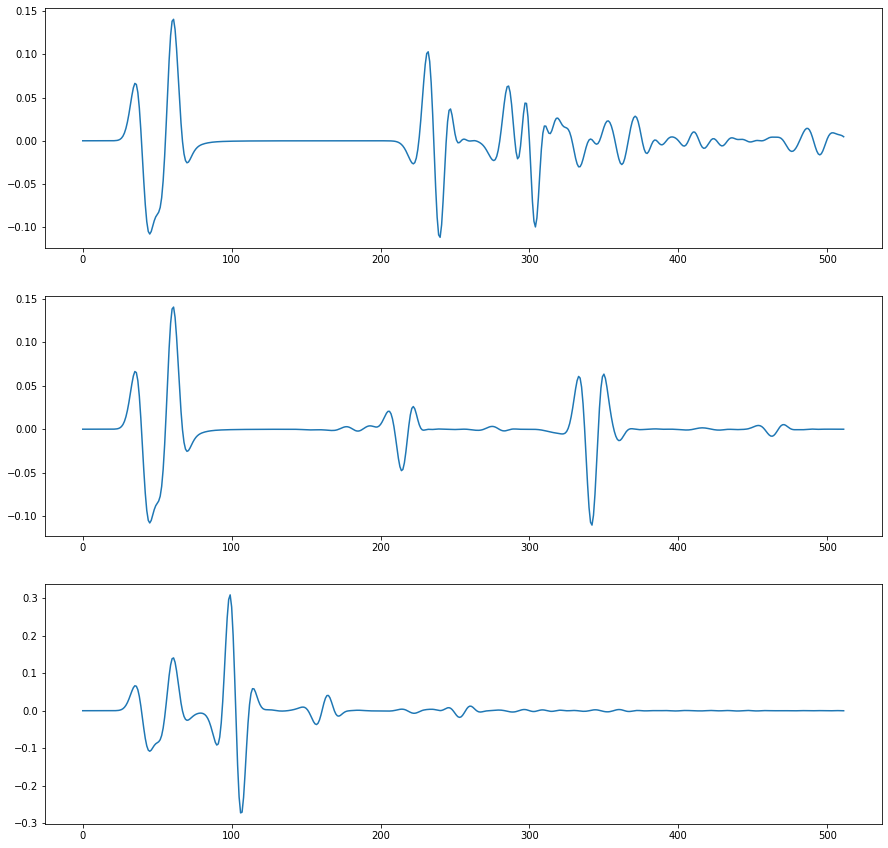

In [ ]:
data_ascans_scall, ascans_scaller = normalization2(data_ascans)

visualizate_random_dataset_ascan_sample(data_ascans_scall)

## Model deconvolution

### Create and fit 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras import optimizers

def deconvolution(input_shape, activation, datalen):
  # imput_tensor = Input(shape=(1,1), tensor = tf.constant(1., shape = (1,1,1)), name = 'zero_level')
  imput_tensor = Input(shape=(1,1), name = 'zero_level')
  # initializer = tf.keras.initializers.Constant(np.reshape(data_ascans_scall[1:2,:100,:], (100)))
  x = Conv1DTranspose(filters = 1,
                      kernel_size = 100,
                      # kernel_initializer=initializer,
                      strides = 1, 
                      # padding = 'valid', 
                      use_bias = False,
                      activation = activation, name = 'impuls'
                      )(imput_tensor)
  # initializer = tf.keras.initializers.Constant(tf.constant(0., shape = (1,413, datalen)))  
  x = Conv1DTranspose(filters = 1,
                      kernel_size = 413,
                      # kernel_initializer=initializer,
                      strides = 1, 
                      padding = 'valid', 
                      use_bias = False,
                      activation = activation, name = 'trases')(x)


  model = Model(imput_tensor, x)
  model.compile(optimizer=Adam(1e-4),
                loss='mse',
                metrics=['mae'])
  return model




model_dec = deconvolution(data_ascans_scall.shape, activation = 'linear', datalen = datalen)
# utils.plot_model(model_dec, show_shapes=True, dpi=100)
model_dec.summary()

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_level (InputLayer)     [(None, 1, 1)]            0         
                                                                 
 impuls (Conv1DTranspose)    (None, 100, 1)            100       
                                                                 
 trases (Conv1DTranspose)    (None, 512, 1)            413       
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
data_ascans_scall.shape

(201344, 512, 1)

In [ ]:
# data_ascans_scall_swapaxes = np.swapaxes(data_ascans_scall, 0,2)
# data_ascans_scall_swapaxes.shape

# plt.plot(data_ascans_scall_swapaxes[0,:,1])
# plt.plot()
data_ascans_scall_swapaxes[:,:100,:datalen].shape

(1, 100, 1000)

In [ ]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='mae', 
                                      factor=0.1, 
                                      patience=1, 
                                      verbose=0,
                                      min_lr=0.0000000000000000001)

earlystop=EarlyStopping(monitor='loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

# input = np.array([[1]])
zeroes = np.zeros_like(data_ascans_scall[:datalen,:100,:])
zeroes[0] = 1.
history = model_dec.fit(data_ascans_scall[:datalen,:100,:],
                        data_ascans_scall[:datalen,:,:], 
                         epochs=100, 
                         verbose=1, 
                         shuffle=True,
                         callbacks=[
                            #  earlystop, 
                             reduceLROnPlateau, 
                            #  model_checkpoint_callback
                             ],
                          )
# history = model_dec.fit(input,
#                         data_ascans_scall_swapaxes[:,:,:datalen], 
#                          epochs=5, 
#                          verbose=1, 
#                          shuffle=True,
#                          callbacks=[
#                              earlystop, 
#                              reduceLROnPlateau, 
#                             #  model_checkpoint_callback
#                              ],
#                           )

Epoch 1/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0012 - mae: 0.0222 - lr: 1.0000e-19
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0012 - mae: 0.0222 - lr: 1.0000e-19
Epoch 3/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0222 - lr: 1.0000e-19
Epoch 4/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0222 - lr: 1.0000e-19
Epoch 5/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0012 - mae: 0.0222 - lr: 1.0000e-19
Epoch 6/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0222 - lr: 1.0000e-19
Epoch 7/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0012 - mae: 0.0222 - lr: 1.0000e-19
Epoch 8/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0012 - mae: 0.0222 - lr: 1.0000e-19
Epoch 9/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0012 - mae: 0.0222 - lr: 1.0000e-19
Epoch 10/1

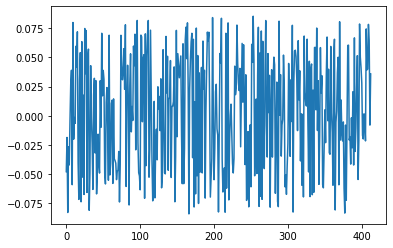

In [ ]:
trace = np.reshape(np.array(model_dec.layers[1].weights), 413)
plt.plot(trace)
plt.show()

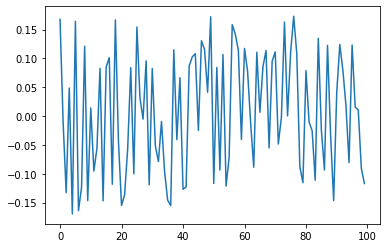

In [ ]:
pulse = np.reshape(np.array(model_dec.layers[1].weights), 100)

plt.plot(pulse)
plt.show()

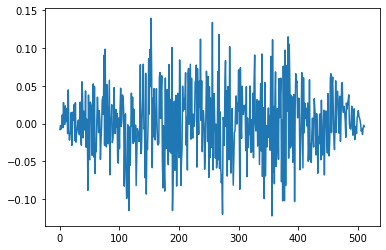

In [ ]:
imp_trace = np.zeros(413)
imp_trace[0]  = 1
imp_trace[150] = -0.1
conv_signal = np.convolve(trace, pulse)
# print(conv_signal.shape)
plt.plot(conv_signal)
plt.show()